<a href="https://colab.research.google.com/github/Timliuw/DP-Tim/blob/main/CI_Tim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import random
import math
import numpy as np
import copy
import time
import pandas as pd
import uuid
import json
import gc
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterSciNotation

from tqdm import tqdm
import string

In [9]:
Run_Locally = True
# Google Spreadsheet
import gspread
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials
from oauth2client.service_account import ServiceAccountCredentials
if not Run_Locally:
    from google.colab import files
# uploaded = files.upload()
import os
os.listdir()

scope = [
    "https://spreadsheets.google.com/feeds",  # Google Sheets API
    "https://www.googleapis.com/auth/drive"   # Google Drive API
]

if Run_Locally:
    creds = ServiceAccountCredentials.from_json_keyfile_name("/u4/tlli/sublime-mission-447319-c2-0df1612796a8.json", scope)
else:
    creds = ServiceAccountCredentials.from_json_keyfile_name("sublime-mission-447319-c2-0df1612796a8.json", scope)
client = gspread.authorize(creds)

spreadsheet = client.open_by_key("1yVVt5ACdBbjsZ_7IiRkvPGIHmpKe8mFXcvyL0PVP2cE")

worksheet1 = spreadsheet.get_worksheet(0)
worksheet = worksheet1
worksheet2 = spreadsheet.get_worksheet(1)

def get_color(curr_value, prev_value):
    if curr_value < 0.6 * prev_value:
        return {"red": 0.6, "green": 1.0, "blue": 0.6}  # very green
    elif curr_value < prev_value:
        return {"red": 0.8, "green": 1.0, "blue": 0.8}  # green
    elif curr_value > 1.4 * prev_value:
        return {"red": 1.0, "green": 0.6, "blue": 0.6}  # very red
    elif curr_value > prev_value:
        return {"red": 1.0, "green": 0.8, "blue": 0.8}  # red
    return None

def write_to_sheet(worksheet, row_data, output_mode=0, compare=False):
    # Append the new row to the sheet
    try:
        worksheet.append_row(row_data)
    except Exception as e:
        print(f"Error occurred: {e}")
        print(f"Row data: {row_data}")
    # Format colour according to the comparing results
    if compare:
        pre_row_index = -2
        if (output_mode == 2): pre_row_index = -18
        sheet_data = worksheet.get_all_values()
        last_row_index = len(sheet_data)
        if last_row_index > 1:
            last_row = sheet_data[-1]
            prev_row = sheet_data[pre_row_index]
            for col_index, (curr_value, prev_value) in enumerate(zip(last_row, prev_row), start=1):
                try:
                    curr_value = float(curr_value)
                    prev_value = float(prev_value)
                    if (worksheet.row_values(1)[col_index-1] == "est median"):
                      prev_value = abs(true_med - prev_value)
                      curr_value = abs(true_med - curr_value)
                    color = get_color(curr_value, prev_value)
                    if color:
                        worksheet.format(f"{chr(64 + col_index)}{last_row_index}", {"backgroundColor": color})
                except:
                    continue

In [10]:
def discretize(D, b):
    n = len(D)
    discreteD = np.zeros(n)
    for i in range(n):
        discreteD[i] = int(D[i]/b)
    return discreteD

def discrete(D):
    n = len(D)
    newD = np.zeros(n)
    previous = -1
    for i in range(n):
        if D[i]!=previous:
            newD[i] = n*D[i]
            #print(newD[i])
            previous = D[i]
        elif D[i]==previous:
            newD[i] = newD[i-1]+1

    return newD

def count(D, a):
    counter = 0
    n = len(D)
    low = 0
    up=n-1
    mid = int((low+up)/2)
    while True:
        if D[mid]>a:
            up=mid
            mid = int((low+up)/2)
        if D[mid]<a:
            low=mid
            mid = int((low+up)/2)
        if D[mid]==a:
            i=0
            while D[mid+i]==a:
                i+=1
            return mid+i

def clip(D, a, b):
    clipped = copy.deepcopy(D)
    clipped[clipped<a] = a
    clipped[clipped>b] = b
    return clipped

def LapNoise():
    a = random.uniform(0,1)
    b = math.log(1/(1-a))
    c = random.uniform(0,1)
    if c>0.5:
        return b
    else:
        return -b

def F(x):
    return 1/2+1/(4*math.pi)*(math.log(abs(2*x**2+2*math.sqrt(2)*x+2)/abs(abs(2*x**2-2*math.sqrt(2)*x+2)))+2*math.atan(math.sqrt(2)*x+1)+2*math.atan(math.sqrt(2)*x-1))
def inver_F(y):
    #find the solution of F(x)=y
    #Find between -1000000 and 1000000 because F(1000000)=1.0 in python
    if y>1/2:
        low =0.0
        high = 1000000.0
        mid = (high+low)/2
        while abs(high-low)>0.0000001:
            if F(mid)>y:
                high=mid
            elif F(mid)==y:
                return mid
            else:
                low = mid
            mid = (high+low)/2

        return high
    if y==1/2:
        return 0

def CauchyNoise():
    a = random.uniform(0.5,1)
    b = inver_F(a)
    c = random.uniform(0,1)
    if c>0.5:
        return b
    else:
        return -b

In [11]:
# Their algorithm
def constructu(eps, a,b, D,sensitivity = 0.5):
    # global u
    # global l
    # global weight
    #[a,b] denotes range
    n = len(D)

    u = np.zeros(n+2)#utility score
    l = np.zeros(n+2)#corresponding data
    l[0] = a
    for i in range(n+1): #i=rank-1
        if i<=int(n/2):
            u[i] = -int(n/2)-1+i
            l[i+1]= D[i]
        #u[int(n/2+1)] = 0
        #l[int(n/2+2)] = D[int(n/2)]
        if i>int(n/2):
            u[i] = int(n/2)+1-i
            l[i]= D[i-1]

    l[n+1] = b
    u[n+1] = -n-1-u[0]
    weight = []
    # l[i] corresponds to data in D with rank i
    for i in range(int(n/2)+1): # build weight[0...n/2]
        weight.append((l[i+1]-l[i])*math.pow(np.e, eps*u[i]/(2*sensitivity))) # weight[i]=(l[i+1]-l[i])...
    weight.append(1) # weight[n/2+1] = 1
    for i in range(int(n/2)+1,n+1): # build weight[n/2+2..n+1]
        weight.append((l[i]-l[i-1])*math.pow(np.e, eps*u[i]/(2*sensitivity))) # weight[i+1]=(l[i]-l[i-1])...
        # which means weight[i] corresponds to interval [ l[i-1],l[i-2] ) for i > int(n/2)+1
        # should be:
        # weight.append((l[i+1]-l[i])*math.pow(np.e, eps*u[i]/(2*sensitivity))) # weight[i+1]=(l[i+1]-l[i])...
    totalWeight = sum(weight)
    weight = weight/totalWeight
    # if show_EM_median_u:
    #   print("totalWeight",totalWeight)
    #   df["Their u"] = list(u)
    #   df['Their weights'] = weight
    return u, l, weight

def EMMedian_new(l,weight):
    i = np.random.choice(list(range(len(l))), p=weight) # choose index i from 0 to n+1
    # pick i with weight[i]
    # only return int
    if i==int(n/2)+1:
        return int(l[i]/n)
    if i<int(n/2)+1:
        return int(np.random.randint(l[i], l[i+1],dtype=np.int64) / n)
    if i>int(n/2)+1:
        return int(np.random.randint(l[i-1], l[i],dtype=np.int64) / n) # bug?

def constructu_CI(eps, beta, N, n, u, l,sensitivity = 0.5):
    # global u1
    # global weight1
    # global u2
    # global weight2
    # global factor
    if show_EM_median_u:
      return [],[],[],[],0
    factor = int(8/eps*np.log(4*n*N/beta))
    print("factor is "+str(factor))
    #u1: left util
    #u2: right util
    u1 = np.zeros(n+2)
    u2 = np.zeros(n+2)
    for i in range(n+2):
        if i<=int(n/2)+1:
            u1[i] = -abs(u[i]+factor)
            u2[i] = u[i]-factor
        else:
            u1[i] = u[i]-factor
            u2[i] = -abs(u[i]+factor)

    idx = int(n/2)+1-factor
    weight1 = []
    for i in range(idx):
        weight1.append((l[i+1]-l[i])*math.pow(np.e, eps*u1[i]/(4*sensitivity)))
    weight1.append(1)
    for i in range(idx,n+1):
        weight1.append((l[i]-l[i-1])*math.pow(np.e, eps*u1[i]/(4*sensitivity)))
    totalWeight1 = sum(weight1)
    weight1 = weight1/totalWeight1

    idx = int(n/2)+1+factor
    idx = min(int(n/2)+1+factor,n+1)
    weight2 = []
    for i in range(idx):
        weight2.append((l[i+1]-l[i])*math.pow(np.e, eps*u2[i]/(4*sensitivity)))
    weight2.append(1)
    for i in range(idx,n+1):
        weight2.append((l[i]-l[i-1])*math.pow(np.e, eps*u2[i]/(4*sensitivity)))

    totalWeight2 = sum(weight2)
    weight2 = weight2/totalWeight2
    return u1,weight1,u2,weight2,factor

def EMMedianCI(l,weight,weight1, weight2,factor):
    est = EMMedian_new(l,weight)
    if show_EM_median_u:
      return 0,0,0,est
    i1 = np.random.choice(list(range(len(l))), p=weight1)
    if i1==int(n/2)+1-factor:
        x1= int(l[i1]/n)
    if i1<int(n/2)+1-factor:
        x1= int(np.random.randint(l[i1], l[i1+1],dtype=np.int64)/n)
    if i1>int(n/2)+1-factor:
        x1= int(np.random.randint(l[i1-1], l[i1],dtype=np.int64)/n)

    i2 = np.random.choice(list(range(len(l))), p=weight2)
    if i2==int(n/2)+1+factor:
        x2= int(l[i2]/n)
    if i2<int(n/2)+1+factor:
        x2= int(np.random.randint(l[i2], l[i2+1],dtype=np.int64)/n)
    if i2>int(n/2)+1+factor:
        x2= int(np.random.randint(l[i2-1], l[i2],dtype=np.int64)/n)
    if show_EMCI_u:
      df["left_weight"] = weight1
      df["right_weight"] = weight2
    indicator=0
    if D[int(n/2)]<=x2 and D[int(n/2)]>=x1:
        indicator=1

    return x1,x2 ,indicator,est

In [12]:
eps = []
beta = []
D = []
newD = []
domain_size = 4000
num_repeat = 100
b_list_step = 1
rank_dict = {}
rank_dict_discretized = {}

In [13]:
# Our algorithm
#1) Learn noisy median o of distribution using Exponential Mechanism
def EM_median(eps,beta,D,domain_size,use_discretized = False):
    interval_prob = []
    rank_dict = {}
    # D = np.array([lowest]) + D
    vals, counts = np.unique(D,return_counts=True)
    rank = 0
    n = len(D)
    last_val = vals[-1]
    if use_discretized:
      last_val += n
    else:
      last_val += 1
    vals = vals.tolist() + [int(last_val)]
    counts = counts.tolist() + [0]
    cdf = 0.0
    weights = []
    u = []

    for i in range(0,len(vals)-1):
      rank += counts[i]
      rank_dict[vals[i]] = rank
      utility = -1.0* np.abs(rank - n/2)
      u.append(utility) # u[i] = utility, corresponding to vals[i]
      p = (vals[i+1] - vals[i])* math.pow(np.e, eps*utility/2)
      cdf += p
      weights.append(p) # weight[i] = p, corresponding to interval [vals[i],vals[i+1])
      if use_discretized == 0:
        for j in range(counts[i]-1):
          weights.append(".")
          u.append(".")
      interval_prob.append(cdf)
    rank_dict[vals[-1]] = rank
    # print("our weight len",len(weight))
    rand_val = cdf * np.random.uniform(0,1)
    rank_o = 0
    # print("total weights:",sum(weights))
    if (use_discretized == 0):
      weight_name = 'our weights'
      u_name = 'our u'
    else:
      weight_name = 'our weights(discre)'
      u_name = 'our u(discre)'

    for i in range(0,len(vals)-1):
        if rand_val <= interval_prob[i]:
          o = int(np.random.randint(vals[i], vals[i+1],dtype=np.int64)) # [vals[i],vals[i+1])
          rank_o = rank_dict[vals[i]]
          break

    if show_EM_median_u:
      totalWeight = 0
      for weight in weights:
        try:
          totalWeight +=weight
        except:
          continue
      # print("totalWeight",totalWeight)
      std_weight = []
      for weight in weights:
          try:
              std_weight.append(weight / totalWeight)
          except Exception as e:
              std_weight.append(".")
      df[u_name] = ["."] + u + ["."]
      df[weight_name] = ["."] + weights + ["."]
      df["std_"+weight_name] = ["."] + std_weight + ["."]
    return o,rank_o,rank_dict

#2)
def find_rank(rank_dict, val, vals=None, ranks=None):
    if use_discretized and val in rank_dict_discretized:
         return rank_dict_discretized[val]
    elif not use_discretized and val in rank_dict:
         return rank_dict[val]
    if vals is None:
        vals = list(rank_dict.keys())
        ranks = list(rank_dict.values())
    if val <= vals[0]:
        result = 0
    elif val > vals[-1]:
        result = ranks[-1]
    else:
        left, right = 0, len(vals) - 1
        while left <= right:
            mid = (left + right) // 2
            if val > vals[mid]:
                left = mid + 1
            else:
                right = mid - 1
        result = ranks[left - 1] if left > 0 else 0
    return result



def SVT_median(o,rank_o,rank_dict,eps,D,domain_size,T,b_list):
    # print("T: ", T)
    noisy_T = T + np.random.laplace(2/eps)
    sensitivity = 1
    bounds = domain_size
    #print(min(o+bounds,domain_size-1))
    for b in b_list: #range(0,b_max,step):
        perturbed_value = min(abs(find_rank(rank_dict, o+b)-rank_o),abs(find_rank(rank_dict, o-b)-rank_o)) + np.random.laplace(2*sensitivity/eps)
        if perturbed_value > noisy_T:
            bounds = b
            # print("b:",b,"perturbed_value:",perturbed_value,"noisy_T:",noisy_T)
            break
    result = max(o-bounds,0),min(o+bounds,D[-1])

    return result


def EMCI(D,o,rank_o,rank_dict,eps,b_list,C1,C2,domain_size,sl_in_u=False,precomputed_vals=None,precomputed_ranks=None):
  u = []
  fb_list = []
  weights = []
  interval_prob = []
  cdf = 0.0
  l = 1
  n = len(D)
  if len(b_list) >= 1:
    step_size = b_list[0]
  b_list = list(b_list)

  for i in range(0,len(b_list)):
    b = b_list[i]
    right_bound = abs(find_rank(rank_dict,o+b,vals=precomputed_vals,ranks=precomputed_ranks)-rank_o)
    left_bound = abs(find_rank(rank_dict,o-b,vals=precomputed_vals,ranks=precomputed_ranks)-rank_o)
    fb = min(left_bound,right_bound)
    # print("b:",b/n,"fb:",rank_o,left_bound, right_bound)
    fb_list.append(fb)

    if sl_in_u: utility = -1.0 * abs(fb - C1 - C2 - step_size*l)
    else: utility = -1.0 * abs(fb - C1 - C2)
    u.append(utility) # huge space required?

  sensitivity = 1
  for i in range(0, len(b_list)):
    utility = u[i]
    eps_utility = eps * utility / sensitivity # u is monotonic
    p = np.exp(eps_utility)
    cdf += p
    weights.append(p)
    interval_prob.append(float(cdf))

  if show_EMCI_u and num_repeat == 1:
    original_b = [b/n for b in b_list]
    df['original_b'] = original_b
    df['b'] = b_list
    df['fb'] = fb_list
    df['utility'] = u
    df['weight'] = weights
    df['interval_prob'] = interval_prob

  rand_val = cdf * np.random.uniform(0,1)
  bounds = domain_size
  for i in range(0,len(b_list)):
    b = b_list[i]
    if rand_val <= interval_prob[i]:
      bounds = b
      break
  if sl_in_u:
    result = max(o-bounds,0),min(o+bounds,D[-1])
  else:
    result = max(o-bounds-step_size*l,0),min(o+bounds+step_size*l,D[-1])
  return result


def EMCI_new(D,o,rank_o,rank_dict,eps,b_list,C1,C2,domain_size,precomputed_vals=None,precomputed_ranks=None,sampling_method=0):
  cdf = 0.0
  l = 1
  sensitivity = 1
  n = len(D)
  step_size = b_list[0]
  interval_prob = []
  # b has the same fb value for b in interval [b1,b2]
  b = b_list[0]
  b_intervals = [] # list of [b1,...,bi] (close intervals)
  new_b_list = []
  b_set = set()
  b_set.add(b)
  b_set.add(b_list[-1])
  # Avoid full b_list scan by computing rank-change-triggering b values only
  for val in precomputed_vals:
      b_raw = abs(val - o)  # Distance from o to the jump point
      if b_raw % step_size == 0:
          b_std = int(b_raw)
      else:
          b_std = int((b_raw // step_size + 1) * step_size)
      if b_std > b_list[0] and b_std <= b_list[-1]:
          b_set.add(b_std)

  # Sort and add to new_b_list (deduplicated, ascending order)
  new_b_list = sorted(b_set)
  new_b_list += [new_b_list[-1]+1]
  weights = []
  u = []
  num_bs = []
  fb_list = []
  interval_start = b_list[0]
  rank_1 = find_rank(rank_dict, o-b, vals=precomputed_vals, ranks=precomputed_ranks)
  rank_2 = find_rank(rank_dict, o+b, vals=precomputed_vals, ranks=precomputed_ranks)
  pre_fb = min(abs(rank_1 - rank_o), abs(rank_2 - rank_o))
  fb_list.append(pre_fb)
  for i in range(1, len(new_b_list)):
    b = new_b_list[i]
    if i % 10000 == 0:
        gc.collect()
    rank_1 = find_rank(rank_dict, o-b, vals=precomputed_vals, ranks=precomputed_ranks)
    rank_2 = find_rank(rank_dict, o+b, vals=precomputed_vals, ranks=precomputed_ranks)
    fb = min(abs(rank_1 - rank_o), abs(rank_2 - rank_o))
    if fb != pre_fb:
      # new fb value
      interval_end = new_b_list[i] # [interval_start,interval_end)
      b_intervals.append((interval_start, interval_end))
      utility = -1.0 * abs(pre_fb - C1 - C2 - step_size*l)
      eps_utility = eps * utility / sensitivity # u is monotonic
      # num_b = interval_end - interval_start
      num_b = (interval_end - interval_start) / step_size
      p = num_b * np.exp(eps_utility)
      cdf += p
      interval_prob.append(float(cdf))
      interval_start = b # set the start of the next interval
      pre_fb = fb
      u.append(utility)
      if show_EMCI_u:
        fb_list.append(fb)
        weights.append(p)
        num_bs.append(num_b)
  if (len(b_intervals) == 0 or b_intervals[-1][1]!=new_b_list[-1]): # last b has the same utility
    interval_end = new_b_list[-1]
    b_intervals.append((interval_start, interval_end))
    utility = -1.0 * abs(pre_fb - C1 - C2 - step_size*l)
    eps_utility = eps * utility / sensitivity # u is monotonic
    # num_b = interval_end - interval_start
    num_b = (interval_end - interval_start) / step_size
    p = num_b * np.exp(eps_utility)
    cdf += p
    interval_prob.append(float(cdf))
    interval_start = b # set the start of the next interval
    u.append(utility)
    if show_EMCI_u:
      weights.append(p)
      num_bs.append(num_b)

  # Sample b using either standard exp-mechanism or Gumbel-Max trick
  bounds = domain_size
  gumbel_scores = []
  original_u = []
  if sampling_method == 0 or sampling_method == 1:
    if sampling_method == 1:
      # Shift the utilities by Max(u)
      max_u = max(u)
      original_u = u
      u = [ui - max_u for ui in u]
      weights = np.exp(np.array(u) * eps / sensitivity)
      interval_prob = np.cumsum(weights)
      cdf = interval_prob[-1]
    rand_val = cdf * np.random.uniform(0, 1)
    chosen_idx = None
    for i, prob in enumerate(interval_prob):
        if rand_val <= prob:
          chosen_idx = i
          break

  if chosen_idx is None:
    raise RuntimeError("Sampling failed: no interval matched.")

  # Sample b from selected interval
  interval = b_intervals[chosen_idx]
  start, end = int(interval[0]), int(interval[1])
  if (end - start) <= 0:
      raise ValueError("Chosen interval is empty.")
  bounds = random.randrange(start, end, step_size)

  if show_EMCI_u and num_repeat == 1:
    df['b_intervals'] = b_intervals
    df['fb'] = fb_list
    df['original_u'] = original_u
    df['shifted_u'] = u
    df['num_b'] = num_bs
    df['weights'] = weights
    if sampling_method == 2:
        df['gumbel_scores'] = gumbel_scores
  # Construct final result
  result = max(o - bounds, 0), min(o + bounds, D[-1])
  return result



def Their_EMMedian_modified(l,weight,D):
    n = len(D)
    vals, counts = np.unique(D,return_counts=True)
    rank_dict = {}
    rank_dict_record = {}
    rank = 0
    last_val = vals[-1]
    if use_discretized:
      last_val += n
    else:
      last_val += 1
    vals = vals.tolist() + [int(last_val)]
    counts = counts.tolist() + [0]
    for i in range(0,len(vals)-1):
        rank += counts[i]
        rank_dict[vals[i]] = rank
    rank_dict[vals[-1]] = rank
    i = np.random.choice(list(range(len(l))), p=weight)
    # only return int
    val = 0
    if i==int(n/2)+1:
      val = int(l[i])
    if i<int(n/2)+1:
      val = int(np.random.randint(l[i], l[i+1],dtype=np.int64))
    if i>int(n/2)+1:
      val = int(np.random.randint(l[i-1], l[i],dtype=np.int64))
      i=i-1
    # print("est_med:",val/n)
    return val,i,rank_dict #rank_dict is from global variable

##### main function ######

def our_CI(D,domain_size,b_list,med_method=0,CI_method=0,l=[],weight=[],sl_in_u=False,sampling_method=0):
    if len(b_list) >= 1:
      step_size = b_list[0]
    m = len(b_list)
    alpha = (8*np.log(m)+np.log(2/beta_2)) / eps_2
    C = (2/eps_1) *(np.log(domain_size/beta_1)) # γ
    C2 = (1/eps_2) *(np.log(domain_size/(b_list_step*beta_2)))

    T = C + alpha
    if (med_method==0):
      o,rank_o,rank_dict = EM_median(eps_1,beta_1,D,domain_size) #our EM
    elif (med_method==1):
      o,rank_o,rank_dict = Their_EMMedian_modified(l,weight,D) #their EM


    if (CI_method==0):
      lower,upper = SVT_median(o,rank_o,rank_dict,eps_2,D,domain_size,T,b_list)
    elif (CI_method==1):
      precomputed_vals = list(rank_dict.keys())[:-1]
      precomputed_ranks = list(rank_dict.values())[:-1]
      lower,upper = EMCI(D,o,rank_o,rank_dict,eps_2,b_list,C,C2,domain_size,sl_in_u,precomputed_vals,precomputed_ranks)
    elif (CI_method==2):
      precomputed_vals = list(rank_dict.keys())[:-1]
      precomputed_ranks = list(rank_dict.values())[:-1]
      lower,upper = EMCI_new(D,o,rank_o,rank_dict,eps_2,b_list,C,C2,domain_size,precomputed_vals,precomputed_ranks,sampling_method)
    else:
      lower,upper = 0,0 # do not run CI algorithm

    indi = -1 #if CI contains true med
    if (use_discretized == 1):
      if lower < D[0]: lower = D[0]
      if upper > D[-1]: upper = D[-1]
      lower,upper = int(lower/n),int(upper/n)
      o = int(o/n)

    # if true_med < upper and true_med > lower:
    if true_med <= upper and true_med >= lower: #new
        indi = 1
    else:
        indi = 0
    gc.collect()
    return lower,upper,indi,o


In [14]:
def test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D,compare=False,print_res=True,
              output=[],med_method=0,CI_method=0,name="",sl_in_u=False,sampling_method=0,use_discretized=1):
  # med_method: 0 use our EM
  #      : 1 use their EM (use_discretized must = 1)
  domain_size = int(max(D)-min(D))
  if (use_discretized == 1):
    # b_list_step *= n
    b_list = range(b_list_step, b_list_step*int(domain_size/b_list_step)+1,b_list_step)

    u,l,weight = [],[],[]
    if (len(b_list) == 0): b_list = range(0,2)
    if (med_method == 1):
      rad = 10000000
      left = -rad
      u,l,weight=constructu(eps_1,left*n,rad*n, D,sensitivity = 1)
  else:
    # b_list = range(0, domain_size, b_list_step)
    b_list = range(b_list_step, b_list_step*int(domain_size/b_list_step)+1,b_list_step)
    l = 0
    weight = []
  len_eps = []
  err_eps = []
  est_median = []
  times = []
  ranks = []
  lengths = []
  errors = []
  rank_errors_1 = [] # based on n/2
  rank_errors_2 = [] # based on find_rank(rank_dict,true_med)
  rank_CI_lengths = []
  # est_list = []
  med_rank = int(find_rank(rank_dict, true_med))
  # print("rank_dict:",rank_dict)
  # print("med_rank:",med_rank)
  print("Our EM Results, beta = "+str(beta[0]))
  correct_count = 0

  for j in tqdm(range(num_repeat),desc="completed:"):
      start = time.time()
      # xl,xr,indi,est = 0,0,0,0
      xl,xr,indi,est = our_CI(D,domain_size,b_list,med_method,CI_method,l,weight,sl_in_u,sampling_method)
      end = time.time()
      lengths.append((xr-xl)/2)
      times.append(end-start)
      correct_count+=indi
      errors.append(abs(est-true_med))
      est_median.append(est)
      rank = int(find_rank(rank_dict, est))
      ranks.append(rank)
      rank_errors_1.append(int(abs(n/2 - rank)))
      rank_errors_2.append(int(abs(med_rank - rank)))

  original_errors = errors
  errors = np.array(errors, dtype=object)
  err_stddev = np.std(errors)
  correct_rate = correct_count/num_repeat
  avgLength = sum(lengths)/num_repeat
  length_stddev = np.std(lengths)
  errors.sort()
  errorQuantile = errors[int(num_repeat*(1-beta[0]))]
  avg_error = np.average(errors)
  avgTime = sum(times)/len(times)

  # rank CI length
  rank_lower = int(find_rank(rank_dict,xl))
  rank_upper = int(find_rank(rank_dict,xr))
  rank_CI_length = (rank_upper-rank_lower)/2
  rank_CI_lengths.append(rank_CI_length)


  # output medians and error

  #download errors
  # df = pd.DataFrame(errors)
  # file_name = f"data_error.csv"
  # df.to_csv(file_name, index=False, header=False)
  # files.download(file_name)

  # median_error
  if np.all(errors == errors[0]):
      stddev_based_avg_err = errors[0]
      IQR_based_avg_err = errors[0]
  else:
      std_dev = np.std(errors)
      stddev_based_avg_err = np.average(errors[np.abs(errors - avg_error) < 3 * std_dev])
      q1 = np.percentile(errors, 25)
      q3 = np.percentile(errors, 75)
      iqr = q3 - q1
      lower_bound = q1 - 1.5 * iqr
      upper_bound = q3 + 1.5 * iqr
      IQR_based_avg_err = np.average(errors[(errors >= lower_bound) & (errors <= upper_bound)])
  # rank_error
  avg_rank_error_1 = np.average(rank_errors_1)
  avg_rank_error_2 = np.average(rank_errors_2)
  err_rank_stddev = np.std(rank_errors_1)
  # avg rank CI length
  avg_rank_CI_length = np.average(rank_CI_lengths)

  if name=="":
    name = "our_CI"
    if (use_discretized == 1):
      name = "our_CI(discretized)"
      domain_size = int(domain_size/n)
      if (med_method == 1): name = "our_CI(their EM)"
  if (errorQuantile == 0): relative_CI_width = -1
  else: relative_CI_width = avgLength / errorQuantile
  print("last experiment CI:",xl,xr)
  print("avg estimated median value: "+ str(np.average(est_median)))
  print("avg median error: "+ str(avg_error))
  print("Average CI length = "+str(avgLength))
  print("correct rate = ", correct_rate)


  row_data = [
      name, # 0
      data_uuid,
      n,
      domain_size,
      sens,
      beta[0],
      eps[0],
      num_repeat,
      true_med,
      np.average(est_median),
      correct_rate,
      avgLength, # 11
      errorQuantile,
      avg_error, # 13
      stddev_based_avg_err,
      IQR_based_avg_err,
      avg_rank_error_1,
      avg_rank_error_2,
      relative_CI_width,
      avg_rank_CI_length,
      avgTime,
      b_list_step,
      beta_1,
      beta_2,
      eps_1,
      eps_2,
      err_stddev,# 26
      length_stddev, # 27
      err_rank_stddev #29
  ]
  if (output_mode == 0 or output_mode == 2):
    write_to_sheet(worksheet1, row_data, output_mode=output_mode, compare=compare)

  if (output_mode == 1 or output_mode == 2):
    sorted_med = sorted(est_median)
    est_median.insert(0, "Our est_median")
    sorted_med.insert(0, "Sorted Our est_median")

    sorted_errors = sorted(original_errors)
    original_errors.insert(0, "Our errors")
    sorted_errors.insert(0, "Sorted Our errors")

    sorted_ranks = sorted(ranks)
    ranks.insert(0, "Our ranks")
    sorted_ranks.insert(0, "Sorted Our ranks")

    sorted_lengths = sorted(lengths)
    lengths.insert(0,"Our CI lengths")
    sorted_lengths.insert (0, "Sorted Our CI lengths")

    sorted_re_1 = sorted(rank_errors_1)
    sorted_re_2 = sorted(rank_errors_2)
    rank_errors_1.insert(0, "Our rank_errors(n/2)")
    rank_errors_2.insert(0, "Our rank_errors(find)")
    sorted_re_1.insert(0, "Sorted Our rank_errors(n/2)")
    sorted_re_2.insert(0, "Sorted Our rank_errors(find)")


    data_uid_row = ["data:", data_uuid, "method:", "Our_CI"]
    true_med_row = ["true median"]+[true_med]*num_repeat
    n_over_2_row = ["true n/2"] + [n/2]*num_repeat
    med_rank_row = ["true med_rank(find)"] + [med_rank]*num_repeat

    worksheet.append_row(data_uid_row)
    worksheet.append_row(est_median)
    worksheet.append_row(true_med_row)
    worksheet.append_row(original_errors)
    # write_to_sheet(worksheet1, errors, output_mode=output_mode, compare=compare)
    worksheet.append_row(ranks)
    worksheet.append_row(n_over_2_row)
    worksheet.append_row(rank_errors_1)
    # write_to_sheet(worksheet1, rank_errors_1, output_mode=output_mode, compare=compare)
    worksheet.append_row(med_rank_row)
    worksheet.append_row(rank_errors_2)
    worksheet.append_row(lengths)

    # write_to_sheet(worksheet1, rank_errors_2, output_mode=output_mode, compare=compare)
    worksheet.append_row(sorted_med)
    worksheet.append_row(sorted_ranks)
    worksheet.append_row(sorted_errors)
    worksheet.append_row(sorted_re_1)
    worksheet.append_row(sorted_re_2)
    worksheet.append_row(sorted_lengths)
    len_eps.append(avgLength)
    err_eps.append(errorQuantile)
  output = row_data
  return output

In [15]:

def test_theirs(eps=eps, beta=beta, num_repeat=num_repeat, D=newD,median_method = 0,compare = False,output=[],sensitivity=0.5):
  #median_method = 0:median from CI algorithm
  #              = 1:median from EMMedianCI
  n = len(newD)
  domain_size = int((max(D)-min(D))/n)
  len_eps = []
  err_eps = []
  est_median = []
  times = []
  ranks = []
  EM_median_errors = []
  med_rank = int(find_rank(rank_dict, true_med))
  est_list = []
  rank_errors_1 = [] # based on n/2
  rank_errors_2 = [] # based on find_rank(rank_dict,true_med)
  rank_CI_lengths = []
  for i in range(len(beta)):
      print("Their EM Results, beta = "+str(beta[i]))
      errors = []
      lengths = []
      correct_count = 0
      rad = 10000000
      left=-rad
      u,l,weight = constructu(eps[i], left*n,rad*n, newD,sensitivity=sensitivity)
      u1,weight1,u2,weight2,factor = constructu_CI(eps[i],beta[i],rad,len(D),u,l,sensitivity=sensitivity)
      for j in range(num_repeat):
          start = time.time()
          xl,xr,indi,est = EMMedianCI(l,weight,weight1,weight2,factor)
          end = time.time()
          times.append(end-start)
          correct_count+=indi
          lengths.append((xr-xl)/(2))
          if (median_method == 0):
            their_median = (xr+xl)/2 # median from EMCI
          else:
            their_median = est # median from their EM_Median
          est_median.append(their_median)
          errors.append(abs(their_median-true_med))
          EM_median_errors.append(abs(est-true_med)) # their def of errors
          rank = int(find_rank(rank_dict, their_median))
          ranks.append(rank)
          rank_errors_1.append(int(abs(n/2 - rank)))
          rank_errors_2.append(int(abs(med_rank - rank)))

          # rank CI length
          rank_lower = int(find_rank(rank_dict,xl))
          rank_upper = int(find_rank(rank_dict,xr))
          rank_CI_length = (rank_upper-rank_lower)/2
          rank_CI_lengths.append(rank_CI_length)

      original_errors = errors
      errors = np.array(errors, dtype=object)
      correct_rate = correct_count/num_repeat
      avgLength = sum(lengths)/num_repeat
      length_stddev = np.std(lengths)
      errors.sort()
      errorQuantile = errors[int(num_repeat*(1-beta[i]))]

      avgTime = sum(times)/len(times)


      errors = np.array(errors)
      avg_error = np.average(errors)
      err_stddev = np.std(errors)
      if (errorQuantile == 0): relative_CI_width = -1
      else: relative_CI_width = avgLength / errorQuantile
      if np.all(errors == errors[0]):
          stddev_based_avg_err = errors[0]
          IQR_based_avg_err = errors[0]
      else:
          std_dev = np.std(errors)
          stddev_based_avg_err = np.average(errors[np.abs(errors - avg_error) < 3 * std_dev])

          q1 = np.percentile(errors, 25)
          q3 = np.percentile(errors, 75)
          iqr = q3 - q1
          lower_bound = q1 - 1.5 * iqr
          upper_bound = q3 + 1.5 * iqr
          IQR_based_avg_err = np.average(errors[(errors >= lower_bound) & (errors <= upper_bound)])

      #rank_error avg
      avg_rank_error_1 = np.average(rank_errors_1)
      avg_rank_error_2 = np.average(rank_errors_2)
      err_rank_stddev = np.std(rank_errors_1)
      # avg rank CI length
      avg_rank_CI_length = np.average(rank_CI_lengths)

      print("last experiment CI:",xl,xr)
      print("avg estimated median value: "+ str(np.average(est_median)))
      print("avg median error: "+ str(avg_error))
      print("Average CI length = "+str(avgLength))
      print("correct rate = ", correct_rate)
      # print("Errors:", errors)
      # print("Standard Deviation:", std_dev)
      # print("Filtered Errors for stddev_based_avg_err:", errors[np.abs(errors - avg_error) < 3 * std_dev])

      # print("Q1:", q1, "Q3:", q3)
      # print("IQR:", iqr)
      # print("Lower Bound:", lower_bound, "Upper Bound:", upper_bound)
      if (median_method == 0):
        name = "EM_CI"
      else:
        name = "EM"
      row_data = [
          name,
          data_uuid,
          n,
          domain_size, #3
          sens, #4
          beta[i],#5
          eps[i], #6
          num_repeat, #7
          true_med, #8
          np.average(est_median), #9
          correct_rate, #10
          avgLength, #11
          errorQuantile, #12
          avg_error,#13
          stddev_based_avg_err, #14
          IQR_based_avg_err, #15
          avg_rank_error_1, #16
          avg_rank_error_2, #17
          relative_CI_width, #18
          avg_rank_CI_length, #19
          avgTime, #20
          err_stddev, #21
          length_stddev, #22
          err_rank_stddev, #23
      ]
      if (output_mode == 0 or output_mode == 2):
        write_to_sheet(worksheet1, row_data, compare = compare)

      if (output_mode == 1 or output_mode == 2):
        sorted_med = sorted(est_median)
        est_median.insert(0, "EM est_median")
        sorted_med.insert(0, "Sorted EM est_median")

        sorted_errors = sorted(original_errors)
        original_errors.insert(0, "EM errors")
        sorted_errors.insert(0, "Sorted EM errors")

        sorted_ranks = sorted(ranks)
        ranks.insert(0, "EM ranks")
        sorted_ranks.insert(0, "Sorted EM ranks")

        sorted_re_1 = sorted(rank_errors_1)
        sorted_re_2 = sorted(rank_errors_2)
        rank_errors_1.insert(0, "EM rank_errors(n/2)")
        rank_errors_2.insert(0, "EM rank_errors(find)")
        sorted_re_1.insert(0, "Sorted EM rank_errors(n/2)")
        sorted_re_2.insert(0, "Sorted EM rank_errors(find)")

        sorted_lengths = sorted(lengths)
        lengths.insert(0,"EM CI lengths")
        sorted_lengths.insert (0, "Sorted EM CI lengths")

        data_uid_row = ["data:", data_uuid, "method:", "EM_CI"]
        true_med_row = ["true median"]+[true_med]*num_repeat
        n_over_2_row = ["true n/2"] + [n/2]*num_repeat
        med_rank_row = ["true med_rank(find)"] + [med_rank]*num_repeat

        worksheet.append_row(data_uid_row)
        worksheet.append_row(est_median)
        worksheet.append_row(true_med_row)

        worksheet.append_row(original_errors)
        # write_to_sheet(worksheet1, original_errors, output_mode=output_mode, compare=compare)
        worksheet.append_row(ranks)
        worksheet.append_row(n_over_2_row)
        worksheet.append_row(rank_errors_1)
        # write_to_sheet(worksheet1, rank_errors_1, output_mode=output_mode, compare=compare)
        worksheet.append_row(med_rank_row)
        worksheet.append_row(rank_errors_2)
        worksheet.append_row(lengths)
        # write_to_sheet(worksheet1, rank_errors_2, output_mode=output_mode, compare=compare)
        worksheet.append_row(sorted_med)
        worksheet.append_row(sorted_ranks)
        worksheet.append_row(sorted_errors)
        worksheet.append_row(sorted_re_1)
        worksheet.append_row(sorted_re_2)
        worksheet.append_row(sorted_lengths)



      len_eps.append(avgLength)
      err_eps.append(errorQuantile)
      output = row_data
      return output

In [16]:
def readInput(mode,read_data_uuid="64b7c8bf89f14113bd12f5f15e276546"):
    import numpy as np
    file_paths = {
        0: ("./bank_marketing.csv", 5),
        1: ("./adult.csv", 2),
        2: ("./california_housing_test.csv", 3),
        3: ("./california_housing_test.csv", 8),
        5: ("./ratings_small.csv",3),
        6: ("./airplane_price_dataset.csv",1),
        7: ("./airplane_price_dataset.csv",2),
        8: ("./airplane_price_dataset.csv",3),
        9: ("./airplane_price_dataset.csv",4),
        10: ("./data_"+read_data_uuid+".csv",0),
        11: ("./healthcare.csv",1),
        12: ("./healthcare.csv",2),
        13: ("./Estate_Sales.csv",1),
        14: ("./Estate_Sales.csv",2),
        15: ("./airplane_price_dataset_modified.csv",1),
    }

    if mode not in file_paths:
        raise ValueError("Invalid mode.")

    input_path, column_index = file_paths[mode]
    if Run_Locally:
       input_path = "./Data"+input_path[1:]
    with open(input_path, 'r',errors='ignore') as input_file:
        lines = input_file.readlines()
    n = len(lines)
    # D = np.zeros(n)
    D = np.zeros(n-1) #new! there are n-1 data points
    for i, line in enumerate(lines):
        if i > 0:
            elements = line.split(",")
            try:
                value = float(elements[column_index])
                D[i - 1] = int(value)
            except ValueError:
              if (column_index < len(elements)):
                print(f"Skipping invalid data at line {i}: {elements[column_index]}")
    return D

def normalize_non_negative(D):
  lowest = min(D)
  if lowest<0:
    D = [d-lowest for d in D]
  return D

In [17]:
def color_vertically(worksheet,col=10,smaller_better=True,row_number=4):
  # row_number: number of rows you want to colour
  # Define the column indices
  col_true = 9
  values_I = worksheet.col_values(col_true)
  values_col = worksheet.col_values(col)

  # Extract the last k rows (ensuring they are numeric)
  last_4_true = [float(values_I[-row_number + i]) for i in range(row_number)]
  last_4_vals = [float(values_col[-row_number + i]) for i in range(row_number)]

  if (col==10):
    diffs = [abs(last_4_vals[i] - last_4_true[i]) for i in range(row_number)]
  else:
    diffs = last_4_vals

  # Rank differences from smallest to largest
  if smaller_better:
      sorted_indices = sorted(range(len(diffs)), key=lambda k: diffs[k])
  else:
      sorted_indices = sorted(range(len(diffs)), key=lambda k: diffs[k], reverse=True)


  # Define colors for ranking
  colors = [
    {"red": 0.0, "green": 1.0, "blue": 0.0},  # Green (best)
    {"red": 0.6, "green": 1.0, "blue": 0.6},  # Light Green
    {"red": 1.0, "green": 0.6, "blue": 0.6},  # Light Red
    {"red": 1.0, "green": 0.0, "blue": 0.0},  # Red (worst)
  ]

  # Get the last 4 row indices
  base_row = len(values_col) - row_number+1  # First of the last 4 rows (1-based index)

  # Apply formatting
  for rank, index in enumerate(sorted_indices):
    row = base_row + index  # Correct row number
    cell = f"{chr(64 + col)}{row}"  # Convert column number to letter (J)
    worksheet.format(cell, {"backgroundColor": colors[rank]})

In [18]:
def color_horizontally(worksheet,col_n=4,starting_col = 2):
    # starting_col starts from 1
    # col_n starts from 0
    starting_col = starting_col - 1
    col_end = starting_col + col_n - 1

    # Get the last row values from Column B to Column E
    last_row = worksheet.row_values(len(worksheet.get_all_values()))
    # Convert the values to floats (or int if appropriate)
    values_b_to_end = [float(value) for value in last_row[starting_col:col_end+1]]  # Ensure values are numeric
    # Define colors for ranking
    colors = [
        {"red": 0.0, "green": 1.0, "blue": 0.0},  # Green (min)
        {"red": 0.6, "green": 1.0, "blue": 0.6},  # Light Green (2nd smallest)
        {"red": 1.0, "green": 0.6, "blue": 0.6},  # Light Red
        {"red": 1.0, "green": 0.0, "blue": 0.0},  # Red (max)
    ]
    if col_n==3:
      colors = [
        {"red": 0.0, "green": 1.0, "blue": 0.0},  # Green (min)
        {"red": 0.6, "green": 1.0, "blue": 0.6},  # Light Green (2nd smallest
        {"red": 1.0, "green": 0.0, "blue": 0.0},  # Red (max)
      ]
    if col_n==5:
      colors = [
        {"red": 0.0, "green": 1.0, "blue": 0.0},  # Green (min)
        {"red": 0.6, "green": 1.0, "blue": 0.6},  # Light Green (2nd smallest)
        {"red": 1.0, "green": 1.0, "blue": 1.0},
        {"red": 1.0, "green": 0.6, "blue": 0.6},  # Light Red
        {"red": 1.0, "green": 0.0, "blue": 0.0},  # Red (max)
      ]

    if col_n == 7 or 6:
      colors = [
          {"red": 0.0, "green": 1.0, "blue": 0.0},  # Pure Green
          {"red": 0.4, "green": 0.8, "blue": 0.4},  # Darker Green
          {"red": 0.6, "green": 1.0, "blue": 0.6},  # Light Green
          {"red": 1.0, "green": 1.0, "blue": 1.0},  # White
          {"red": 1.0, "green": 0.8, "blue": 0.8},  # Light Red
          {"red": 1.0, "green": 0.5, "blue": 0.5},  # Darker Red
          {"red": 1.0, "green": 0.0, "blue": 0.0}   # Pure Red
      ]

    # Sort the values and map them to their ranks
    sorted_indices = sorted(range(len(values_b_to_end)), key=lambda k: values_b_to_end[k])
    rank_map = {sorted_indices[i]: i for i in range(len(sorted_indices))}  # Map index to rank
    def get_excel_columns(starting_col, col_n):
      all_cols = list(string.ascii_uppercase)
      return all_cols[starting_col : starting_col + col_n]

    columns = get_excel_columns(starting_col, col_n)
    # Loop through each value and apply the background color based on its rank
    for i, value in enumerate(values_b_to_end):
        col_letter = columns[i]  # Get column letter
        cell = f"{col_letter}{len(worksheet.get_all_values())}"  # Cell reference
        rank = rank_map[i]  # Get the rank from the rank map
        worksheet.format(cell, {"backgroundColor": colors[rank]})


In [19]:
def build_rank_dict(D, discretized=False):
    n = len(D)
    vals, counts = np.unique(D, return_counts=True)
    rank_dict = {}
    rank = 0
    last_val = vals[-1] + (n if discretized else 1)
    vals = vals.tolist() + [int(last_val)]
    counts = counts.tolist() + [0]

    for i in range(len(vals) - 1):
        rank += counts[i]
        rank_dict[vals[i]] = rank
    rank_dict[vals[-1]] = rank

    return rank_dict


In [20]:
def Run_and_Plot(D, our_CI_only=False, b_list_step=1, num_repeat=50):
    global eps_1,eps_2
    errindex = 13
    # errindex = 16 # rank err
    CIindex = 11
    # CIindex = 19 # rank CI length
    eps_list = [0.25, 0.5, 1, 2, 4]
    CI_method = 2
    methods = ["Their_EMCI", "Our_EMCI"] if not our_CI_only else ["Our_EMCI"]
    method_labels = {
        "Their_EMCI": "Their CI",
        "Our_EMCI": "Our CI"
    }

    error_records = {m: [] for m in methods}
    error_std_records = {m: [] for m in methods}
    ci_records = {m: [] for m in methods}
    ci_std_records = {m: [] for m in methods}
    df = pd.DataFrame()
    for eps_val in eps_list:
        eps = [eps_val]
        eps_1 = 0.6 * eps[0]
        eps_2 = eps[0] - eps_1
        print("---------Running eps: " + str(eps_val) + "---------")

        if not our_CI_only:
            theirs_output = test_theirs(
                eps=eps, beta=beta, num_repeat=num_repeat,
                median_method=0, D=D, sensitivity=0.5
            )
            error_records["Their_EMCI"].append(theirs_output[errindex])
            error_std_records["Their_EMCI"].append(theirs_output[21])
            ci_records["Their_EMCI"].append(theirs_output[CIindex])
            ci_std_records["Their_EMCI"].append(theirs_output[22])

        ours_output = test_ours(b_list_step=1,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=2,sl_in_u=True,sampling_method=1)
        error_records["Our_EMCI"].append(ours_output[errindex])
        error_std_records["Our_EMCI"].append(ours_output[26])
        ci_records["Our_EMCI"].append(ours_output[CIindex])
        ci_std_records["Our_EMCI"].append(ours_output[27])

    eps_strs = [str(eps) for eps in eps_list]
    print("error_records:", error_records)
    print("error_std_records:", error_std_records)
    print("ci_records:", ci_records)
    print("ci_std_records:", ci_std_records)
    # ---------- Plot: Average Median Error vs. Epsilon ----------
    plt.figure(figsize=(10, 6))
    for m in methods:
        plt.errorbar(eps_strs, error_records[m], yerr=error_std_records[m],
                     fmt='s--', capsize=4, label=method_labels[m])
    plt.xlabel("Epsilon")
    plt.ylabel("Average Median Error")
    plt.title("Median Error vs. Epsilon")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("median_error_vs_epsilon_custom.png", dpi=300)
    plt.show()

    # ---------- Plot: Average CI Length vs. Epsilon ----------
    plt.figure(figsize=(10, 6))
    for m in methods:
        plt.errorbar(eps_strs, ci_records[m], yerr=ci_std_records[m],
                     fmt='s--', capsize=4, label=method_labels[m])
    plt.xlabel("Epsilon")
    plt.ylabel("Average CI Length")
    plt.title("CI Length vs. Epsilon")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("ci_length_vs_epsilon_custom.png", dpi=300)
    plt.show()

In [21]:
def Run_and_Get_Results(D, our_CI_only=False, b_list_step=1, num_repeat=100):
    global eps_1, eps_2
    eps_list = [0.25, 0.5, 1, 2, 4]

    results = {
        'their_results': [],
        'our_results': []
    }   

    for eps_val in eps_list:
        eps = [eps_val]
        eps_1 = 0.6 * eps[0]
        eps_2 = eps[0] - eps_1
        print("---------Running eps: " + str(eps_val) + "---------")

        if not our_CI_only:
            their_output = test_theirs(
                eps=eps, beta=beta, num_repeat=num_repeat,
                median_method=0, D=D, sensitivity=0.5
            )
            results['their_results'].append(their_output)
        our_output = test_ours(
            b_list_step=b_list_step, eps=eps, beta=beta,
            num_repeat=num_repeat, D=D, CI_method=2,
            sl_in_u=True, sampling_method=1
        )
        results['our_results'].append(our_output)

    return results


def Run_Hyperparam_Tuning(D, num_repeat=100, tune_var='b_list_step', r_list=[0.3,0.4,0.5,0.6,0.7], b_step_config_fn=None):
    eps_list = [0.25, 0.5, 1, 2, 4]
    results_set = []
    if tune_var == 'r':
        assert r_list is not None, "r_list must be provided when tune_r=True"
        for r in r_list:
            our_results = []
            for eps_val in eps_list:
                eps = [eps_val]
                eps_1 = r * eps[0]
                eps_2 = eps[0] - eps_1
                b_list_step = 1  # fixed default

                print(f"[Tuning r] r={r:.2f}, eps={eps_val}, b_list_step={b_list_step}")
                output = test_ours(
                    b_list_step=b_list_step,
                    eps=eps,
                    beta=beta,
                    num_repeat=num_repeat,
                    D=D,
                    CI_method=2,
                    sl_in_u=True,
                    sampling_method=1
                )
                our_results.append(output)
            results_set.append({
                "config": f"r={r:.2f}",
                "our_results": our_results
            })
    elif tune_var == 'b_list_step':
        assert b_step_config_fn is not None, "b_step_config_fn must be provided when tuning b_list_step"
        for b_label in ["fixed_1", "inv_eps", "inv_eps_x10", "n"]:
            our_results = []
            for eps_val in eps_list:
                eps = [eps_val]
                eps_1 = 0.6 * eps[0]
                eps_2 = eps[0] - eps_1
                b_list_step = b_step_config_fn(b_label, eps_2, D)

                print(f"[Tuning b_step] config={b_label}, eps={eps_val}, b_list_step={b_list_step}")
                output = test_ours(
                    b_list_step=b_list_step,
                    eps=eps,
                    beta=beta,
                    num_repeat=num_repeat,
                    D=D,
                    CI_method=2,
                    sl_in_u=True,
                    sampling_method=1
                )
                our_results.append(output)
            results_set.append({
                "config": b_label,
                "our_results": our_results
            })

    return results_set



In [46]:
# Plot functions
def _set_plot_style():
    font = {'size': 16}
    plt.rc('font', **font)

def _plot_with_shaded_error(ax, x, y, yerr, label, xlabel, ylabel, title, xticks=None, xticklabels=None):
    ax.plot(x, y, label=label, linewidth=2)
    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if xticks is not None and xticklabels is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
    ax.grid(True)
    ax.legend()


def Plot_Results(data_uuid, our_CI_only=False, save_fig=False):
    errindex, CIindex = 13, 11
    eps_list = [0.25, 0.5, 1, 2, 4]
    eps_labels = [str(eps) for eps in eps_list]
    x_array = np.arange(len(eps_list))

    eps_array = np.array(eps_list)
    with open(data_uuid + '_result.json', 'r') as f:
        results = json.load(f)
    _set_plot_style()
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    if not our_CI_only:
        their_error = np.array([r[errindex] for r in results['their_results']])
        their_error_std = np.array([r[21] for r in results['their_results']])
        their_ci = np.array([r[CIindex] for r in results['their_results']])
        their_ci_std = np.array([r[22] for r in results['their_results']])

    our_error = np.array([r[errindex] for r in results['our_results']])
    our_error_std = np.array([r[26] for r in results['our_results']])
    our_ci = np.array([r[CIindex] for r in results['our_results']])
    our_ci_std = np.array([r[27] for r in results['our_results']])

    # Plot Median Error
    if not our_CI_only:
        _plot_with_shaded_error(axes[0], x_array, their_error, their_error_std, "Their CI",
                                "Epsilon", "Average Median Error", "Median Error vs. Epsilon",
                                xticks=x_array, xticklabels=eps_labels)
    _plot_with_shaded_error(axes[0], x_array, our_error, our_error_std, "Our CI",
                            "Epsilon", "Average Median Error", "Median Error vs. Epsilon",
                            xticks=x_array, xticklabels=eps_labels)

    # Plot CI Length
    if not our_CI_only:
        _plot_with_shaded_error(axes[1], x_array, their_ci, their_ci_std, "Their CI",
                                "Epsilon", "Average CI Length", "CI Length vs. Epsilon",
                                xticks=x_array, xticklabels=eps_labels)
    _plot_with_shaded_error(axes[1], x_array, our_ci, our_ci_std, "Our CI",
                            "Epsilon", "Average CI Length", "CI Length vs. Epsilon",
                            xticks=x_array, xticklabels=eps_labels)


    plt.tight_layout()
    if save_fig:
        plt.savefig(f"{data_uuid}_results_epsilon.pdf", format='pdf')
    plt.show()

def Plot_Results_fixed_eps(x_axis="domain_size", epsilon_fixed=1, save_fig=False, our_CI_only=False):
    import matplotlib.pyplot as plt
    import numpy as np
    import json
    from matplotlib.ticker import LogFormatterSciNotation

    errindex, CIindex = 13, 11
    eps_index_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
    domain_sizes = [1e3, 5e3, 1e4, 5e4, 1e5, 1e6, 1e7]
    ab_list = [(0.5, 8), (1, 5), (1, 2), (1, 1), (2, 1), (5, 1), (8, 0.5)]
    skew_labels = [
        "Strong Right", "Moderate Right", "Mild Right",
        "Uniform", "Mild Left", "Moderate Left", "Strong Left"
    ]

    x_axis_value = domain_sizes if x_axis == "domain_size" else ab_list
    x_vals, labels = [], []

    our_median, our_median_std, their_median, their_median_std = [], [], [], []
    our_ci, our_ci_std, their_ci, their_ci_std = [], [], [], []

    for i, x in enumerate(x_axis_value):
        if x_axis == "domain_size":
            data_uuid = f"N={int(x)}"
            label = x
        else:
            a, b = x
            data_uuid = f"Beta(a={a},b={b})"
            label = skew_labels[i]

        try:
            with open(data_uuid + '_result.json', 'r') as f:
                results = json.load(f)
            idx = eps_index_map[epsilon_fixed]

            # Our
            our_median.append(results['our_results'][idx][errindex])
            our_median_std.append(results['our_results'][idx][26])
            our_ci.append(results['our_results'][idx][CIindex])
            our_ci_std.append(results['our_results'][idx][27])

            if not our_CI_only:
                their_median.append(results['their_results'][idx][errindex])
                their_median_std.append(results['their_results'][idx][21])
                their_ci.append(results['their_results'][idx][CIindex])
                their_ci_std.append(results['their_results'][idx][22])

            labels.append(label)
            x_vals.append(x)
        except FileNotFoundError:
            print(f"File {data_uuid}_result.json not found, skipping.")

    _set_plot_style()
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    if x_axis == "domain_size":
        x_vals_np = np.array(x_vals)
    else:
        x_vals_np = np.arange(len(labels))

    # Plot median error
    axes[0].plot(x_vals_np, our_median, label="Our CI", linewidth=2)
    axes[0].fill_between(x_vals_np, np.array(our_median) - np.array(our_median_std),
                         np.array(our_median) + np.array(our_median_std), alpha=0.2)

    if not our_CI_only:
        axes[0].plot(x_vals_np, their_median, label="Their CI", linewidth=2)
        axes[0].fill_between(x_vals_np, np.array(their_median) - np.array(their_median_std),
                             np.array(their_median) + np.array(their_median_std), alpha=0.2)

    axes[0].set_xlabel("Domain Size" if x_axis == "domain_size" else "Skewness Level")
    axes[0].set_ylabel("Median Error")
    axes[0].set_title(f"Median Error (ε = {epsilon_fixed})")
    axes[0].legend(loc='upper right')
    axes[0].grid(True)

    # Plot CI length
    axes[1].plot(x_vals_np, our_ci, label="Our CI", linewidth=2)
    axes[1].fill_between(x_vals_np, np.array(our_ci) - np.array(our_ci_std),
                         np.array(our_ci) + np.array(our_ci_std), alpha=0.2)

    if not our_CI_only:
        axes[1].plot(x_vals_np, their_ci, label="Their CI", linewidth=2)
        axes[1].fill_between(x_vals_np, np.array(their_ci) - np.array(their_ci_std),
                             np.array(their_ci) + np.array(their_ci_std), alpha=0.2)

    axes[1].set_xlabel("Domain Size" if x_axis == "domain_size" else "Skewness Level")
    axes[1].set_ylabel("CI Length")
    axes[1].set_title(f"CI Length (ε = {epsilon_fixed})")
    axes[1].legend(loc='upper right')
    axes[1].grid(True)

    if x_axis == "domain_size":
        for ax in axes:
            ax.set_xscale("log")
            ax.xaxis.set_major_formatter(LogFormatterSciNotation())
            ax.tick_params(axis='x', which='minor', bottom=False)
    else:
        for ax in axes:
            ax.set_xticks(x_vals_np)
            ax.set_xticklabels(labels, rotation=30, ha='right')

    plt.tight_layout()
    if save_fig:
        plt.savefig(f"results_fixed_eps_{x_axis}_log.pdf", format='pdf')
    plt.show()

# x_axis = eps, each line represents our results with different hyperparameters
def Plot_Results_multiple_configs(results_set, data_uuid, config_labels=None, save_fig=False):
    errindex, CIindex = 13, 11
    eps_list = [0.25, 0.5, 1, 2, 4]
    eps_array = np.array(eps_list)

    _set_plot_style()
    if config_labels is None:
        config_labels = [f"Config {i+1}" for i in range(len(results_set))]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for i, results in enumerate(results_set):
        our_error = np.array([r[errindex] for r in results['our_results']])
        our_error_std = np.array([r[26] for r in results['our_results']])
        our_ci = np.array([r[CIindex] for r in results['our_results']])
        our_ci_std = np.array([r[27] for r in results['our_results']])

        # Median Error subplot
        axes[0].plot(eps_array, our_error, label=config_labels[i], linewidth=2)
        axes[0].fill_between(eps_array, our_error - our_error_std, our_error + our_error_std, alpha=0.2)

        # CI Length subplot
        axes[1].plot(eps_array, our_ci, label=config_labels[i], linewidth=2)
        axes[1].fill_between(eps_array, our_ci - our_ci_std, our_ci + our_ci_std, alpha=0.2)

    xtick_labels = [str(eps) for eps in eps_list]

    for ax in axes:
        ax.set_xticks(eps_array)
        ax.set_xticklabels(xtick_labels)
        ax.grid(True)
        ax.legend(loc='upper right')

    axes[0].set_xlabel("Epsilon")
    axes[0].set_ylabel("Median Error")
    axes[0].set_title("Median Error vs. Epsilon")

    axes[1].set_xlabel("Epsilon")
    axes[1].set_ylabel("CI Length")
    axes[1].set_title("CI Length vs. Epsilon")

    plt.tight_layout()
    if save_fig:
        plt.savefig(f"{data_uuid}_multi_config_vs_epsilon.pdf", format='pdf')
    plt.show()


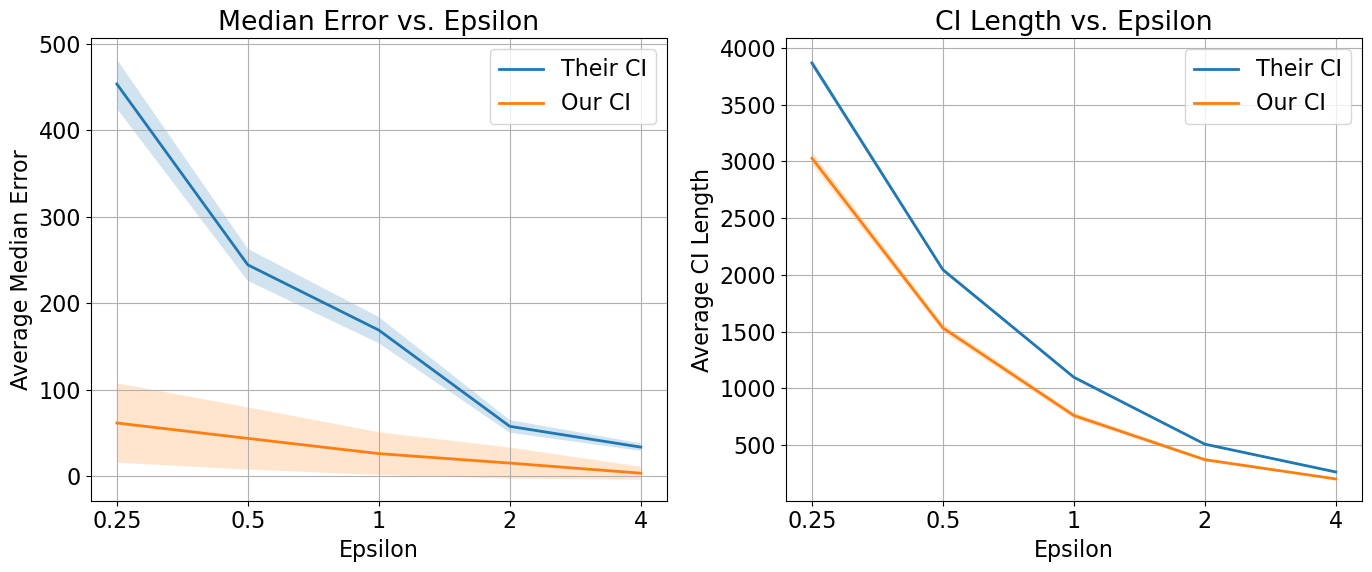

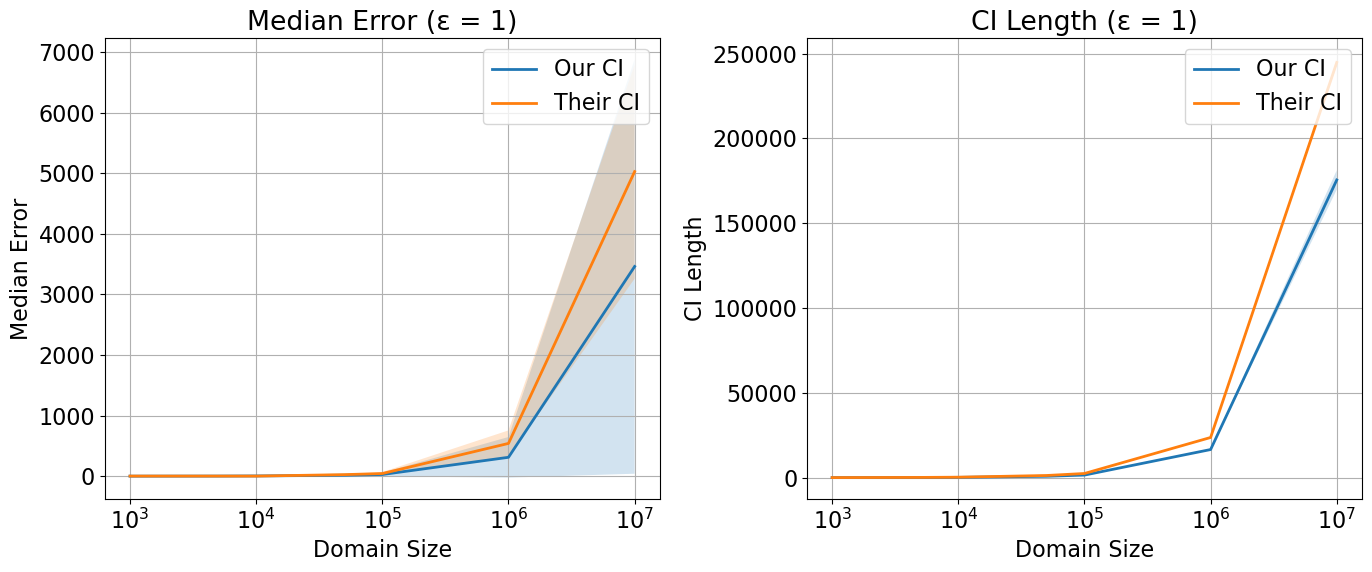

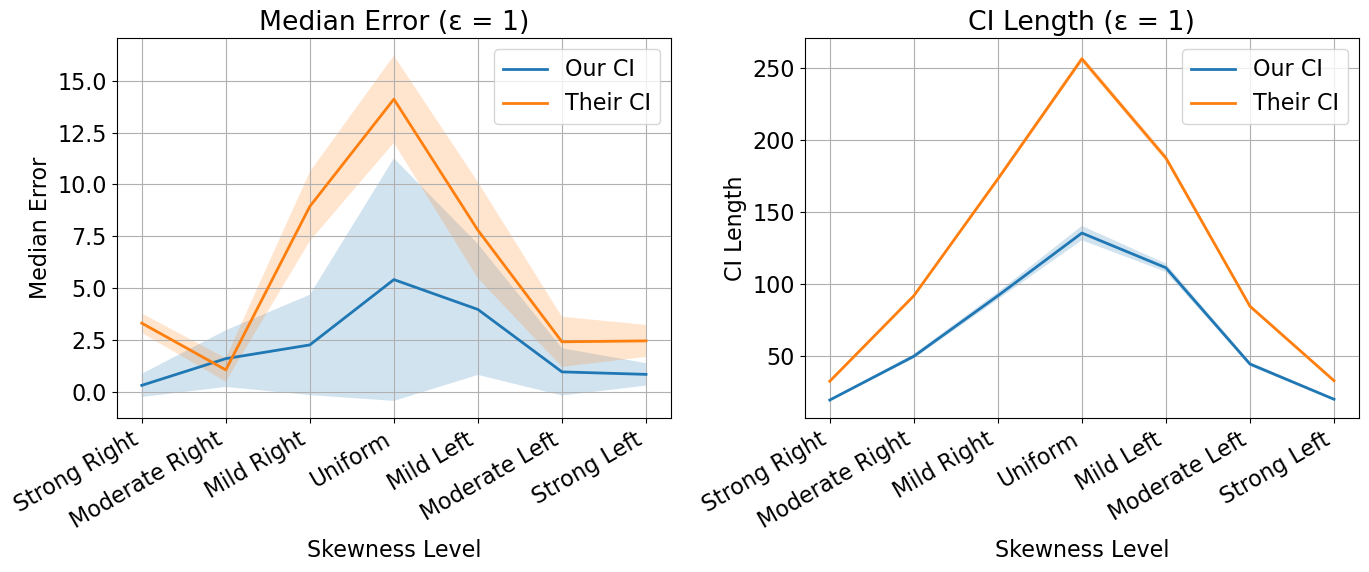

In [47]:
# 1. Epsilon 变化绘图
Plot_Results(data_uuid="adult", our_CI_only=False)

# 2. 固定 epsilon，横轴为 domain size 或 skewness
Plot_Results_fixed_eps(x_axis="domain_size", epsilon_fixed=1)
Plot_Results_fixed_eps(x_axis="skewness", epsilon_fixed=1)


Dataset: airplane_price
-----------airplane_price-----------
lowest,hightest in the original dataset: 145814.0 978213228.0
Data_size: 12377
Domain size: 978067414.0
true median: 83921913.0
true median rank: 6188.5


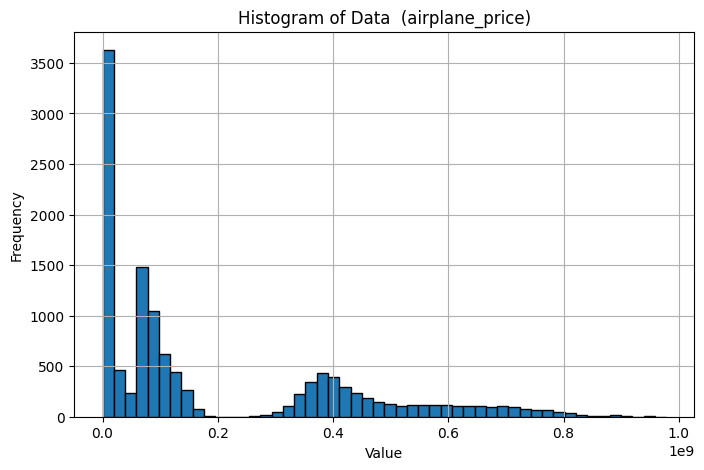

In [69]:
# Experiment Data Input
dataset_id_dict = {0:"bank_marketing", 1:"adult", 2:"cali_housing_test", 3:"cali_housing_value",
        5:"IMDB_time",6:"airplane_capacity",7:"airplane_range",8:"airplane_maintenance",9:"airplane_price",
        10: "old_synthetic_data",11:"healthcare_age",12:"healthcare_bill",13:"estate_assesval",14:"estate_saleamount"}

def Load_and_Process_data(mode=-1,distribution=None):
    global D, newD, rank_dict, rank_dict_discretized,domain_size,n,true_med,data_uuid

    if (mode == -1):
        if (distribution == "uniform"):
            n = 10000  # 45#000
            domain_size = domain_size
            D = np.random.uniform(0, domain_size+1, n)

        # normal distribution
        # n = 1000
        # mean = 1
        # std_dev = 1
        # D = np.random.normal(loc=mean, scale=std_dev, size=n) * 8000

        # gamma distribution
        # n = 10000
        # alpha = 0.5
        # beta_g = 5000
        # D = np.random.gamma(alpha, beta_g, n)

        # Laplace distribution
        # n = 10000
        # mean = 0
        # std_dev = 1000
        # D = np.random.laplace(loc=mean, scale=std_dev, size=n)

        # Exponential Distribution
        # scale = 2000
        # D = np.random.exponential(scale=scale, size=4000)

        # Beta Distribution
        if distribution == "beta":
            global a, b
            n = 10000
            scale = 10000
            D = np.random.beta(a, b, n)
            D = D * scale


        # Log Distribution
        # mean = 0
        # std_dev = 0.5
        # n = 3000
        # scale = 80000
        # D = np.random.lognormal(mean, std_dev, n) * scale
        D = D.astype(int)
    else:
        D = readInput(mode,read_data_uuid="2c368240d51540a9b0c2ab422f38ffdb")
    # D = [1,2,3,4,4,5,7,8,9,10]
    if (mode == -1):
        # data_uuid = uuid.uuid4().hex
        if distribution == "uniform":
            data_uuid = f"N={int(domain_size)}"
        if distribution == "beta":
            data_uuid = f"Beta(a={a},b={b})"
    else:
        data_uuid = dataset_id_dict[mode]
    print("Dataset:",data_uuid)

    lowest = min(D)
    highest = max(D)
    print("-----------"+data_uuid+"-----------")
    print("lowest,hightest in the original dataset:",lowest, highest)
    if (lowest < 0):
        D = normalize_non_negative(D)
        lowest = min(D)
        highest = max(D)

    df = pd.DataFrame(D)
    domain_size = highest - lowest
    n = len(D)

    D.sort()
    D = discretize(D, 1)
    newD = discrete(D)
    true_med = np.median(D)

    print("Data_size:", n)
    print("Domain size:", domain_size)
    print("true median:", true_med)
    # rank_dict
    rank_dict= build_rank_dict(D)
    rank_dict_discretized = build_rank_dict(newD,discretized=True)

    # print("rank_dict_discretized:",rank_dict_discretized)
    # keys = rank_dict.keys()
    # ranks = rank_dict.values()
    # print(next(iter(keys)),lowest,next(reversed(keys)),highest)

    print("true median rank:",n/2)
    # print("rank_dict:",rank_dict)
    # Data Persistence
    if (mode == -1):
        df = pd.DataFrame(D)
        file_name = f"data_{data_uuid}.csv"
        df.to_csv(file_name, index=False, header=False)
        # files.download(file_name)
        print(f"File saved as {file_name}")
    
    plt.figure(figsize=(8, 5))
    plt.hist(D, bins=50, edgecolor='black')
    plt.title("Histogram of Data "+ f" ({data_uuid})")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
# D,newD,rank_dict,rank_dict_discretized = Load_and_Process_data(mode=6)
Load_and_Process_data(mode=9);

In [16]:
# CI Parameters
eps = [1]
beta = [0.01]
sens = 1 #fixed
num_repeat = 1
# for val, rank in rank_dict.items():
#     print(val,"  ",rank)

# Parameters for our_CI
beta_1 = 0.5 *beta[0]
beta_2 = beta[0] - beta_1
# eps_1 = 0.5 * eps[0]
# eps_2 = eps[0] - eps_1
eps_1 = 0.6 * eps[0]
eps_2 = eps[0] - eps_1

print("γ1:",(2/eps_1) *(np.log(domain_size/beta_1))) # γ)

b_list_step = 1

download = 0

use_discretized = 1
show_EM_median_u = True
show_EMCI_u = False

γ1: 86.66468840880627


In [ ]:
# Run Befor

In [ ]:
# Test both

# output_mode 0:experiment results,
#        1:medians&ranks, CI legnths
#        2:both
#        3:return row_result and do not write to google spreadsheet

# EM_mode  0: use our original EM
#       1: use our original EM with discretized data
#       2: use their EM with discretized data
Load_and_Process_data(mode=9)
output_mode = 3
download = 1
df = pd.DataFrame()
print("-------------------EMCI Test--------------------")
df["rank"] = [0]+list(range(1,len(D)+1)) + ['.']
df["data"] = ['.']+list(D)+ ['.']
df["discretized_data"] = ['.'] + list(newD) + [',']
# test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD,sensitivity=0.5) #test EM
print("-------------------ourCI Test--------------------")
result = test_ours(b_list_step=1,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=2,sl_in_u=True,sampling_method=1)


# Result Persistence
if (show_EM_median_u or show_EMCI_u):
  csv_name = "weight"+data_uuid
  df.to_csv(csv_name+".csv",index=False)
  if (download == 1):
    files.download(csv_name+".csv")

In [ ]:
# get real-world dataset experiment results
import json
output_mode = 3
download = 0
df = pd.DataFrame()
download = 0
use_discretized = 1
show_EM_median_u = False
show_EMCI_u = False
mode_list = [0,1,2,3,6,7,8,9,11,12]

for mode in mode_list:
  Load_and_Process_data(mode=mode)
  result = Run_and_Get_Results(D=newD, our_CI_only=False, b_list_step=1, num_repeat=100)
  with open(data_uuid + '_result.json', 'w') as f:
      json.dump(result, f, indent=2)

    # with open(data_uuid + '_result.json', 'r') as f:
    # result = json.load(f)


In [ ]:
# get synthetic dataset experiment(domain_size) results
import json
output_mode = 3
download = 0
df = pd.DataFrame()
download = 0
use_discretized = 1
show_EM_median_u = False
show_EMCI_u = False
domain_sizes = [1e3, 5e3, 1e4, 5e4, 1e5, 1e6, 1e7]

for domain_size in domain_sizes:
  Load_and_Process_data(mode=-1,distribution="uniform")
  result = Run_and_Get_Results(D=newD, our_CI_only=False, b_list_step=1, num_repeat=100)
  with open(data_uuid + '_result.json', 'w') as f:
      json.dump(result, f, indent=2)

    # with open(data_uuid + '_result.json', 'r') as f:
    # result = json.load(f)


In [ ]:
# get synthetic dataset experiment(skewness) results
import json
output_mode = 3
download = 0
df = pd.DataFrame()
download = 0
use_discretized = 1
show_EM_median_u = False
show_EMCI_u = False
# use beta distribution
ab_list = [
    (0.5, 8),   # Strong right skew (most values near 0)
    (1, 5),     # Moderate right skew
    (1, 2),     # Mild right skew
    (1, 1),     # Uniform (no skew)
    (2, 1),     # Mild left skew
    (5, 1),     # Moderate left skew
    (8, 0.5)    # Strong left skew (most values near 1)
]

for ab in ab_list:
  a = ab[0]
  b = ab[1]
  Load_and_Process_data(mode=-1,distribution="beta")
  result = Run_and_Get_Results(D=newD, our_CI_only=False, b_list_step=1, num_repeat=100)
  with open(data_uuid + '_result.json', 'w') as f:
      json.dump(result, f, indent=2)

    # with open(data_uuid + '_result.json', 'r') as f:
    # result = json.load(f)


In [ ]:
# get hyperparameter tuning results
import json
output_mode = 3
download = 0
df = pd.DataFrame()
download = 0
use_discretized = 1
show_EM_median_u = False
show_EMCI_u = False
mode_list = [0,1,2,3,6,7,8,9,11,12]
for mode in mode_list:
  Load_and_Process_data(mode=mode)
  result = Run_and_Get_Results(D=newD, our_CI_only=False, b_list_step=1, num_repeat=100)
  with open(data_uuid + '_result.json', 'w') as f:
      json.dump(result, f, indent=2)

    # with open(data_uuid + '_result.json', 'r') as f:
    # result = json.load(f)


In [ ]:
# Workshop experiment table
mode_list = [0,1,2,3,6,7,8,9,11,12]
# mode_list = [0]
first_row = ["Method","Dataset","Avg Error","Avg Error Rank","Avg CI Length","Avg CI Length Rank","Correct Rate"]
worksheet.append_row(first_row)
for mode in mode_list:
    Load_and_Process_data(mode=mode)
    with open(data_uuid + '_result.json', 'r') as f:
        result = json.load(f)
    
    our_results = result['our_results']
    their_results = result['their_results']
    row_data_ours = [
        "Our EMCI",
        dataset_id_dict[mode],
        f"{our_results[2][13]}(±{our_results[2][26]:.2f})",
        f"{our_results[2][17]}(±{our_results[2][28]:.2f})",
        f"{our_results[2][11]}(±{our_results[2][27]:.2f})",
        our_results[2][19],
        our_results[2][10]
    ]

    row_data_theirs = [
        "Their EMCI",   
        dataset_id_dict[mode],
        f"{their_results[2][13]}(±{their_results[2][21]:.2f})",
        f"{their_results[2][17]}(±{their_results[2][23]:.2f})",
        f"{their_results[2][11]}(±{their_results[2][22]:.2f})",
        their_results[2][19],
        their_results[2][10]
    ]

    
    write_to_sheet(worksheet,row_data_theirs,output_mode=0,compare=False)
    write_to_sheet(worksheet,row_data_ours,output_mode=0,compare=False)

In [ ]:
# workshop real world dataset experiment graphs
mode_list = [0,1,2,3,6,7,8,9,11,12]
for mode in mode_list:
    Load_and_Process_data(mode=mode)
    Plot_Results(data_uuid, our_CI_only=False)

In [ ]:
# workshop synthetic dataset experiment(domain_size) graphs
domain_sizes = [1e3, 5e3, 1e4, 5e4, 1e5, 1e6, 1e7]
for domain_size in domain_sizes:
    data_uuid = f"N={int(domain_size)}"
    with open(data_uuid + '_result.json', 'r') as f:
        result = json.load(f)

    Plot_Results(result, data_uuid, our_CI_only=False)

In [ ]:
# workshop synthetic dataset experiment(skewness) graphs
ab_list = [
    (0.5, 8),   # Strong right skew (most values near 0)
    (1, 5),     # Moderate right skew
    (1, 2),     # Mild right skew
    (1, 1),     # Uniform (no skew)
    (2, 1),     # Mild left skew
    (5, 1),     # Moderate left skew
    (8, 0.5)    # Strong left skew (most values near 1)
]
for ab in ab_list:
    a = ab[0]
    b = ab[1]
    data_uuid = f"Beta(a={a},b={b})"
    with open(data_uuid + '_result.json', 'r') as f:
        result = json.load(f)
    Plot_Results(result, data_uuid, our_CI_only=False)

---------Runing eps:0.25---------
Results for EM based median, beta = 0.01
factor is 1052
Filtered Errors for IQR_based_avg_err: 453.0
estimated median value: 178597.5
correct rate = 1.0
Average CI length = 3866.42
error quantile is 504.5
CI length/ error quantile = 7.66386521308226
Average Time to find CI = 0.026825456619262694
[3866.42]
[np.float64(504.5)]
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


last experiment CI: 175033 181290
avg estimated median value: 178172.98
avg median error: 71.18
correct rate =  1.0
Average CI length = 3107.44
error quantile is 223.5
CI length/ error quantile = 13.903534675615212
Average Time to find CI = 1.3138159894943238
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


last experiment CI: 174903 181814
avg estimated median value: 178159.68
avg median error: 82.26
correct rate =  1.0
Average CI length = 3476.28
error quantile is 274.5
CI length/ error quantile = 12.664043715846995
Average Time to find CI = 1.5532175064086915
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


last experiment CI: 175237 181220
avg estimated median value: 178165.34
avg median error: 70.64
correct rate =  1.0
Average CI length = 3029.46
error quantile is 213.5
CI length/ error quantile = 14.189508196721311
Average Time to find CI = 1.7678400468826294
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


last experiment CI: 174885 181287
avg estimated median value: 178156.34
avg median error: 69.38
correct rate =  1.0
Average CI length = 3207.6
error quantile is 336.5
CI length/ error quantile = 9.53224368499257
Average Time to find CI = 1.7644025325775146
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:30<00:00,  1.82s/it]


last experiment CI: 173763 182056
avg estimated median value: 178185.84
avg median error: 99.48
correct rate =  1.0
Average CI length = 4062.32
error quantile is 505.5
CI length/ error quantile = 8.03624134520277
Average Time to find CI = 1.8105611276626588
---------Runing eps:0.5---------
Results for EM based median, beta = 0.01
factor is 526
Filtered Errors for IQR_based_avg_err: 250.29
estimated median value: 178394.79
correct rate = 1.0
Average CI length = 2043.01
error quantile is 298.5
CI length/ error quantile = 6.844254606365159
Average Time to find CI = 0.04168691635131836
[2043.01]
[np.float64(298.5)]
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


last experiment CI: 176598 179758
avg estimated median value: 178160.26
avg median error: 43.92
correct rate =  1.0
Average CI length = 1572.5
error quantile is 151.5
CI length/ error quantile = 10.37953795379538
Average Time to find CI = 1.5149431037902832
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:11<00:00,  1.42s/it]


last experiment CI: 176459 180060
avg estimated median value: 178153.48
avg median error: 51.7
correct rate =  1.0
Average CI length = 1805.37
error quantile is 187.5
CI length/ error quantile = 9.628639999999999
Average Time to find CI = 1.4202310752868652
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


last experiment CI: 176694 179710
avg estimated median value: 178178.18
avg median error: 45.06
correct rate =  1.0
Average CI length = 1532.16
error quantile is 161.5
CI length/ error quantile = 9.487058823529413
Average Time to find CI = 1.279557981491089
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


last experiment CI: 176618 179970
avg estimated median value: 178175.98
avg median error: 42.12
correct rate =  1.0
Average CI length = 1626.88
error quantile is 149.5
CI length/ error quantile = 10.882140468227426
Average Time to find CI = 1.3199070978164673
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


last experiment CI: 176136 180318
avg estimated median value: 178167.74
avg median error: 57.64
correct rate =  1.0
Average CI length = 2132.65
error quantile is 237.5
CI length/ error quantile = 8.979578947368422
Average Time to find CI = 1.2649617528915404
---------Runing eps:1---------
Results for EM based median, beta = 0.01
factor is 263
Filtered Errors for IQR_based_avg_err: 172.22619047619048
estimated median value: 178315.02
correct rate = 1.0
Average CI length = 1101.1
error quantile is 199.0
CI length/ error quantile = 5.533165829145728
Average Time to find CI = 0.027739725112915038
[1101.1]
[np.float64(199.0)]
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it]


last experiment CI: 177377 178946
avg estimated median value: 178164.02
avg median error: 27.32
correct rate =  1.0
Average CI length = 779.59
error quantile is 105.5
CI length/ error quantile = 7.389478672985782
Average Time to find CI = 1.2604578924179077
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


last experiment CI: 177286 179024
avg estimated median value: 178163.54
avg median error: 36.6
correct rate =  1.0
Average CI length = 844.68
error quantile is 164.5
CI length/ error quantile = 5.13483282674772
Average Time to find CI = 1.305479040145874
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:08<00:00,  1.36s/it]


last experiment CI: 177456 178891
avg estimated median value: 178161.98
avg median error: 22.8
correct rate =  1.0
Average CI length = 761.75
error quantile is 79.5
CI length/ error quantile = 9.581761006289309
Average Time to find CI = 1.3611510801315307
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


last experiment CI: 177280 179008
avg estimated median value: 178158.22
avg median error: 20.3
correct rate =  1.0
Average CI length = 805.58
error quantile is 84.5
CI length/ error quantile = 9.533491124260356
Average Time to find CI = 1.2817086887359619
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


last experiment CI: 177000 179317
avg estimated median value: 178171.62
avg median error: 44.0
correct rate =  1.0
Average CI length = 1138.33
error quantile is 140.5
CI length/ error quantile = 8.101992882562277
Average Time to find CI = 1.368097152709961
---------Runing eps:2---------
Results for EM based median, beta = 0.01
factor is 131
Filtered Errors for IQR_based_avg_err: 55.22727272727273
estimated median value: 178201.16
correct rate = 1.0
Average CI length = 508.52
error quantile is 75.5
CI length/ error quantile = 6.735364238410596
Average Time to find CI = 0.01308572769165039
[508.52]
[np.float64(75.5)]
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


last experiment CI: 177757 178533
avg estimated median value: 178156.82
avg median error: 16.68
correct rate =  1.0
Average CI length = 383.26
error quantile is 76.5
CI length/ error quantile = 5.009934640522876
Average Time to find CI = 1.2771890211105346
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


last experiment CI: 177692 178587
avg estimated median value: 178158.88
avg median error: 16.94
correct rate =  1.0
Average CI length = 440.63
error quantile is 98.5
CI length/ error quantile = 4.4734010152284265
Average Time to find CI = 1.2914822959899903
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


last experiment CI: 177757 178530
avg estimated median value: 178154.7
avg median error: 14.16
correct rate =  1.0
Average CI length = 372.48
error quantile is 68.5
CI length/ error quantile = 5.437664233576642
Average Time to find CI = 1.2902275037765503
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


last experiment CI: 177734 178528
avg estimated median value: 178154.7
avg median error: 15.72
correct rate =  1.0
Average CI length = 397.23
error quantile is 61.5
CI length/ error quantile = 6.459024390243902
Average Time to find CI = 1.3204689359664916
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


last experiment CI: 177614 178685
avg estimated median value: 178159.12
avg median error: 23.16
correct rate =  1.0
Average CI length = 514.75
error quantile is 89.5
CI length/ error quantile = 5.751396648044692
Average Time to find CI = 1.3465951538085938
---------Runing eps:4---------
Results for EM based median, beta = 0.01
factor is 65
Filtered Errors for IQR_based_avg_err: 33.94
estimated median value: 178178.44
correct rate = 1.0
Average CI length = 264.2
error quantile is 40.5
CI length/ error quantile = 6.523456790123457
Average Time to find CI = 0.014678196907043457
[264.2]
[np.float64(40.5)]
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


last experiment CI: 177951 178377
avg estimated median value: 178148.62
avg median error: 7.28
correct rate =  1.0
Average CI length = 207.52
error quantile is 45.5
CI length/ error quantile = 4.560879120879121
Average Time to find CI = 1.3028704404830933
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


last experiment CI: 177941 178437
avg estimated median value: 178156.48
avg median error: 14.0
correct rate =  1.0
Average CI length = 224.45
error quantile is 53.5
CI length/ error quantile = 4.195327102803738
Average Time to find CI = 1.3261215019226074
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:05<00:00,  1.30s/it]


last experiment CI: 177937 178353
avg estimated median value: 178144.98
avg median error: 2.8
correct rate =  1.0
Average CI length = 201.56
error quantile is 43.5
CI length/ error quantile = 4.633563218390805
Average Time to find CI = 1.2996825170516968
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


last experiment CI: 177938 178353
avg estimated median value: 178145.56
avg median error: 3.9
correct rate =  1.0
Average CI length = 209.41
error quantile is 49.5
CI length/ error quantile = 4.230505050505051
Average Time to find CI = 1.2072805261611939
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


last experiment CI: 177871 178417
avg estimated median value: 178158.08
avg median error: 17.62
correct rate =  1.0
Average CI length = 270.64
error quantile is 87.5
CI length/ error quantile = 3.0930285714285715
Average Time to find CI = 1.2486623764038085


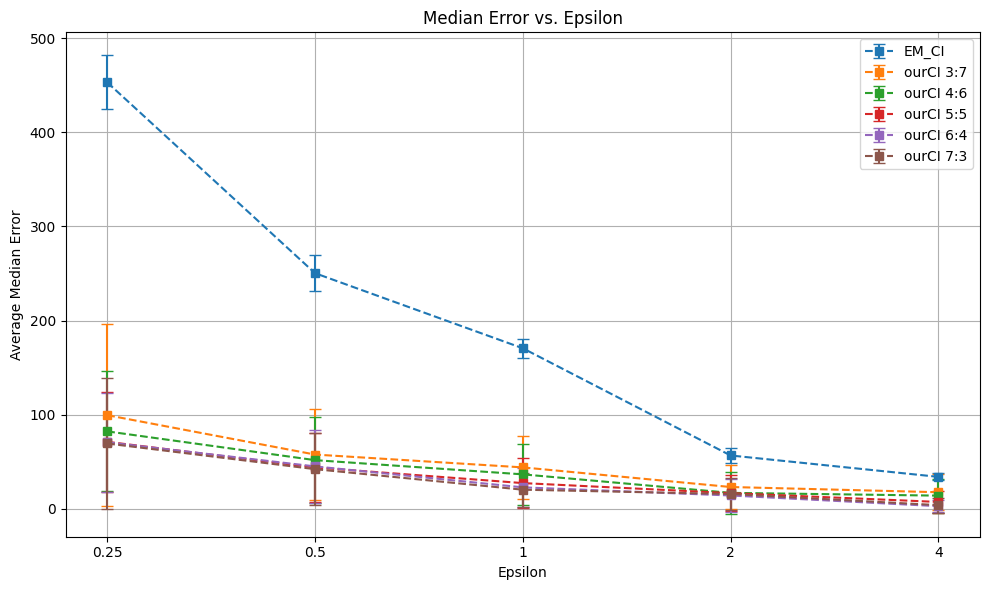

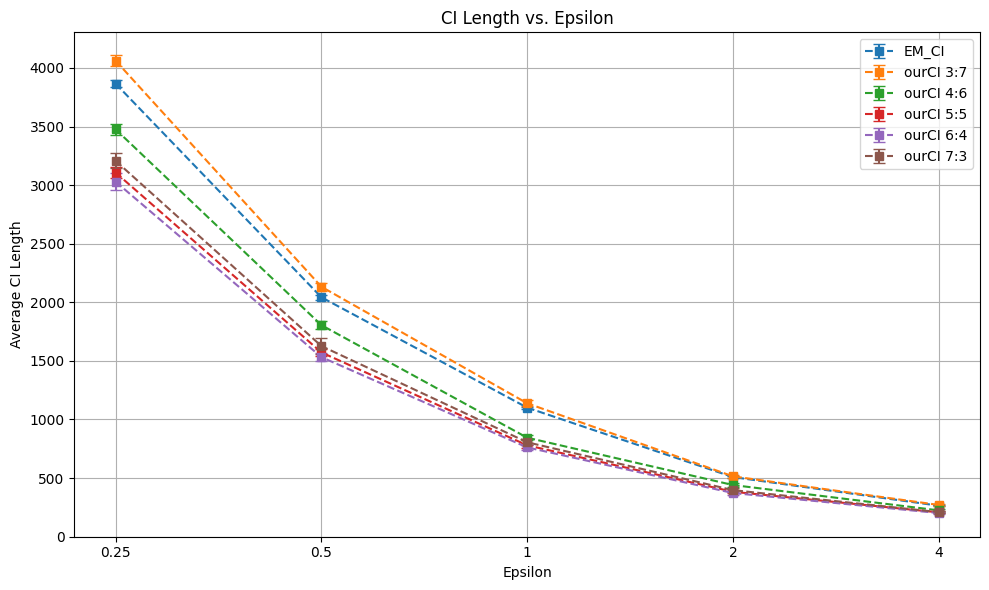

In [ ]:
# Show estimated Median and CI Length
# Test both Median err and CI
# including eps split
output_mode = 3
num_repeat = 50
CIindex = 11
errindex = 13
CI_method = 2
use_discretized = 1
first_row_err = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg Median err","b_step:"+str(b_list_step),"num_repeat:"+str(num_repeat)]
first_row_CI = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg CI length","b_step:"+str(b_list_step),"num_repeat:"+str(num_repeat)]
test_types = ["eps","EM_CI","our_CI 3:7","our_CI 4:6","our_CI 5:5","our_CI 6:4","our_CI 7:3"]
worksheet.append_row(first_row_err+first_row_CI)
worksheet.append_row(test_types+test_types)
eps_list = [0.25,0.5,1,2,4]
df = pd.DataFrame()


# Plotting Purpose
eps_vals = [str(eps_val) for eps_val in eps_list]
methods = ["EM", "3:7", "4:6", "5:5", "6:4", "7:3"]
method_labels = {
    "EM": "EM_CI",
    "3:7": "ourCI 3:7",
    "4:6": "ourCI 4:6",
    "5:5": "ourCI 5:5",
    "6:4": "ourCI 6:4",
    "7:3": "ourCI 7:3"
}

error_records = {m: [] for m in methods}
error_std_records = {m: [] for m in methods}
ci_records = {m: [] for m in methods}
ci_std_records = {m: [] for m in methods}

for eps_val in eps_list:
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD,sensitivity=0.5)
  EMCI_err = EMCI_output[errindex]
  EMCI_CI = EMCI_output[CIindex]
  EMCI_err_stddev = EMCI_output[21]
  EMCI_CI_stddev = EMCI_output[22]

  # even split eps
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  ourCI_output = test_ours(b_list_step=1,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=CI_method,sl_in_u=True,sampling_method=1)
  ourCI_err = ourCI_output[errindex]
  ourCI_CI = ourCI_output[CIindex]
  ourCI_err_stddev = ourCI_output[26]
  ourCI_CI_stddev = ourCI_output[27]

  # eps1:eps2 = 4:6
  eps_1 = 0.4 * eps_val
  eps_2 = eps_val - eps_1
  ourCI2_output = test_ours(b_list_step=1,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=CI_method,sl_in_u=True,sampling_method=1)
  ourCI2_err = ourCI2_output[errindex]
  ourCI2_CI = ourCI2_output[CIindex]
  ourCI2_err_stddev = ourCI2_output[26]
  ourCI2_CI_stddev = ourCI2_output[27]

  # eps1:eps2 = 6:4
  eps_1 = 0.6 * eps_val
  eps_2 = eps_val - eps_1
  ourCI3_output = test_ours(b_list_step=1,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=CI_method,sl_in_u=True,sampling_method=1)
  ourCI3_err = ourCI3_output[errindex]
  ourCI3_CI = ourCI3_output[CIindex]
  ourCI3_err_stddev = ourCI3_output[26]
  ourCI3_CI_stddev = ourCI3_output[27]

  # eps1:eps2 = 7:3
  eps_1 = 0.7 * eps_val
  eps_2 = eps_val - eps_1
  ourCI4_output = test_ours(b_list_step=1,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=CI_method,sl_in_u=True,sampling_method=1)
  ourCI4_err = ourCI4_output[errindex]
  ourCI4_CI = ourCI4_output[CIindex]
  ourCI4_err_stddev = ourCI4_output[26]
  ourCI4_CI_stddev = ourCI4_output[27]

  # eps1:eps2 = 3:7
  eps_1 = 0.3 * eps_val
  eps_2 = eps_val - eps_1
  ourCI5_output = test_ours(b_list_step=1,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=CI_method,sl_in_u=True,sampling_method=1)
  ourCI5_err = ourCI5_output[errindex]
  ourCI5_CI = ourCI5_output[CIindex]
  ourCI5_err_stddev = ourCI5_output[26]
  ourCI5_CI_stddev = ourCI5_output[27]


  RowData_err = [eps_val,EMCI_err,ourCI5_err,ourCI2_err,ourCI_err,ourCI3_err,ourCI4_err]
  RowData_CI = [eps_val,EMCI_CI,ourCI5_CI,ourCI2_CI,ourCI_CI,ourCI3_CI,ourCI4_CI]
  Final_RowData = RowData_err+RowData_CI
  worksheet.append_row(Final_RowData)
  color_horizontally(worksheet,col_n=6)
  color_horizontally(worksheet,col_n=6,starting_col=9)

  error_records["EM"].append(EMCI_err)
  error_std_records["EM"].append(EMCI_err_stddev)
  ci_records["EM"].append(EMCI_CI)
  ci_std_records["EM"].append(EMCI_CI_stddev)

  error_records["3:7"].append(ourCI5_err)
  error_std_records["3:7"].append(ourCI5_err_stddev)
  ci_records["3:7"].append(ourCI5_CI)
  ci_std_records["3:7"].append(ourCI5_CI_stddev)

  error_records["4:6"].append(ourCI2_err)
  error_std_records["4:6"].append(ourCI2_err_stddev)
  ci_records["4:6"].append(ourCI2_CI)
  ci_std_records["4:6"].append(ourCI2_CI_stddev)

  error_records["5:5"].append(ourCI_err)
  error_std_records["5:5"].append(ourCI_err_stddev)
  ci_records["5:5"].append(ourCI_CI)
  ci_std_records["5:5"].append(ourCI_CI_stddev)

  error_records["6:4"].append(ourCI3_err)
  error_std_records["6:4"].append(ourCI3_err_stddev)
  ci_records["6:4"].append(ourCI3_CI)
  ci_std_records["6:4"].append(ourCI3_CI_stddev)

  error_records["7:3"].append(ourCI4_err)
  error_std_records["7:3"].append(ourCI4_err_stddev)
  ci_records["7:3"].append(ourCI4_CI)
  ci_std_records["7:3"].append(ourCI4_CI_stddev)

# ---------- Plot: Average Median Error vs. Epsilon ----------
plt.figure(figsize=(10, 6))
for m in methods:
    plt.errorbar(eps_vals, error_records[m], yerr=error_std_records[m],
                 fmt='s--', capsize=4, label=method_labels[m])

plt.xlabel("Epsilon")
plt.ylabel("Average Median Error")
plt.title("Median Error vs. Epsilon")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("median_error_vs_epsilon.png", dpi=300)
plt.show()

# ---------- Plot: Average CI Length vs. Epsilon ----------
plt.figure(figsize=(10, 6))

for m in methods:
    plt.errorbar(eps_vals, ci_records[m], yerr=ci_std_records[m],
                 fmt='s--', capsize=4, label=method_labels[m])

plt.xlabel("Epsilon")
plt.ylabel("Average CI Length")
plt.title("CI Length vs. Epsilon")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ci_length_vs_epsilon.png", dpi=300)
plt.show()





In [ ]:
# Test any return index
# (use our EM_CI(discretized) and SVT_CI)
output_mode = 3
return_index = 10
experiment_target = "Correct Rate"
column1_title = "eps"
num_repeat = 10
use_opt_stepsize = False
b_list_step = 1
download = 0
show_EM_median_u = False
df = pd.DataFrame()
# worksheet.append_row(["alpha:"+str(alpha),"beta:"+str(beta_g)])
# worksheet.append_row(["mean:"+str(mean),"std_dev:"+str(std_dev)])
# worksheet.append_row(["scale:"+str(scale)])
eps_list = [0.25,0.5,1,2,4] #
if use_opt_stepsize:
  step_option = "opt step"
else:
  step_option = b_list_step
worksheet.append_row([data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),experiment_target,"b_step:"+str(step_option),"num_repeat:"+str(num_repeat)])
worksheet.append_row([column1_title,"their_EM","our_EM","our_EM(sl_in_u)"])


for eps_val in eps_list:
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=1,D=newD,sensitivity=0.5)[return_index]
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(2/eps_2)
  if use_opt_stepsize:
    b_list_step = optimized_step

  use_discretized = 1
  ourCI_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=1,sl_in_u=False)[return_index]

  # ourCI2_output = 0
  ourCI2_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=1,sl_in_u=True)[return_index]
  output_RowData = [eps_val,EMCI_output,ourCI_output,ourCI2_output]
  worksheet.append_row(output_RowData)
  # color_horizontally(worksheet)



In [ ]:
# Test both Median err and CI
# including eps split
output_mode = 3
num_repeat=100
CIindex = 11
errindex = 13
b_list_step = 1
CI_method = 1

first_row_err = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg Median err","b_step:"+str(b_list_step),"num_repeat:"+str(num_repeat)]
first_row_CI = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg CI length","b_step:"+str(b_list_step),"num_repeat:"+str(num_repeat)]
test_types = ["eps","EM_CI","our_CI(b_step)","our_CI(opt)","our_CI 4:6","our_CI(opt) 4:6","our_CI 6:4","our_CI(opt) 6:4"]
worksheet.append_row(first_row_err+first_row_CI)
worksheet.append_row(test_types+test_types)
eps_list = [0.25,0.5,1,2,4]
df = pd.DataFrame()

for eps_val in eps_list:
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD)
  EMCI_err = EMCI_output[errindex]
  EMCI_CI = EMCI_output[CIindex]

  # even split eps
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  use_discretized = 0
  ourCI_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D,CI_method=CI_method  )
  ourCI2_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D,CI_method=CI_method)
  ourCI_err = ourCI_output[errindex]
  ourCI_CI = ourCI_output[CIindex]
  ourCI2_err = ourCI2_output[errindex]
  ourCI2_CI = ourCI2_output[CIindex]

  # eps1:eps2 = 4:6
  eps_1 = 0.4 * eps_val
  eps_2 = eps_val - eps_1
  ourCI3_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI4_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI3_err = ourCI3_output[errindex]
  ourCI3_CI = ourCI3_output[CIindex]
  ourCI4_err = ourCI4_output[errindex]
  ourCI4_CI = ourCI4_output[CIindex]

  # eps1:eps2 = 6:4
  eps_1 = 0.6 * eps_val
  eps_2 = eps_val - eps_1
  ourCI5_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI6_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI5_err = ourCI5_output[errindex]
  ourCI5_CI = ourCI5_output[CIindex]
  ourCI6_err = ourCI6_output[errindex]
  ourCI6_CI = ourCI6_output[CIindex]


  # use_discretized = 1
  # ourCI2_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD)[return_index] #our_CI(discretized)
  # ourCI3_output = test_ours(b_list_step=b_list_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,med_method=1)[return_index] #our_CI(their_EM)
  RowData_err = [eps_val,EMCI_err,ourCI_err,ourCI2_err,ourCI3_err,ourCI4_err,ourCI5_err,ourCI6_err]
  RowData_CI = [eps_val,EMCI_CI,ourCI_CI,ourCI2_CI,ourCI3_CI,ourCI4_CI,ourCI5_CI,ourCI6_CI]
  Final_RowData = RowData_err+RowData_CI
  worksheet.append_row(Final_RowData)
  color_horizontally(worksheet,col_n=7)
  color_horizontally(worksheet,col_n=7,starting_col=10)





In [ ]:
# Test both Median err and CI
# no eps split
output_mode = 3
num_repeat = 1
CIindex = 11
# errindex = 13 # Est Median error
errindex = 10 # this is actually correct rate
b_list_step = 1

# worksheet.append_row(["a="+str(a),"b="+str(b),"scale="+str(scale),"true_med:"+str(true_med)]) # beta distribution parameters
first_row_err = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"correct rate","b_step:opt","num_repeat:"+str(num_repeat)]
first_row_CI = ["avg CI length"]
test_types = ["eps","EM_CI","our_CI","our_CI(sl_in_u)"]
worksheet.append_row(first_row_err+first_row_CI)
worksheet.append_row(test_types+test_types)
eps_list = [0.25,0.5,1,2]
df = pd.DataFrame()

for eps_val in eps_list:
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD)
  EMCI_err = EMCI_output[errindex]
  EMCI_CI = EMCI_output[CIindex]

  # even split eps
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(2/eps_2)
  use_discretized = 1
  ourCI_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=1,sl_in_u=False)
  ourCI2_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=1,sl_in_u=True)
  ourCI_err = ourCI_output[errindex]
  ourCI_CI = ourCI_output[CIindex]
  ourCI2_err = ourCI2_output[errindex]
  ourCI2_CI = ourCI2_output[CIindex]

  RowData_err = [eps_val,EMCI_err,ourCI_err,ourCI2_err]
  RowData_CI = [eps_val,EMCI_CI,ourCI_CI,ourCI2_CI]
  Final_RowData = RowData_err+RowData_CI
  worksheet.append_row(Final_RowData)
  # color_horizontally(worksheet,col_n=3)
  color_horizontally(worksheet,col_n=3,starting_col=6)





---------Runing eps:0.25---------
Results for EM based median, beta = 0.01
factor is 1009
Filtered Errors for IQR_based_avg_err: 300.0
estimated median value: 6000.0
correct rate = 1.0
Average CI length = 300.0
error quantile is 300.0
CI length/ error quantile = 1.0
Average Time to find CI = 0.0032753944396972656
[300.0]
[300.0]
Results for EM based median, beta = 0.01


KeyboardInterrupt: 

In [ ]:
# Test CI with different step size
output_mode = 3
return_index = 11
experiment_target = "Avg CI Length"
column1_title = "eps"
b_list_step = 5
num_repeat = 50
CI_method = 2
sampling_method = 1
show_EMCI_u = False
# worksheet.append_row(["alpha:"+str(alpha),"beta:"+str(beta_g)])
# worksheet.append_row(["mean:"+str(mean),"std_dev:"+str(std_dev),"scale="+str(scale)])
# worksheet.append_row(["a="+str(a),"b="+str(b),"scale="+str(scale),"true_med:"+str(true_med)]) # beta distribution parameters
worksheet.append_row([data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"Avg CI Length","b_step:"+str("different"),"num_repeat:"+str(num_repeat),"true_med:"+str(true_med)])
worksheet.append_row([column1_title,"EM_CI","our_CI(1)","our_CI(opt)","our_CI(opt*2)","our_CI(opt*10)","our_CI(opt*n)"])
eps_list = [0.25,0.5,1,2] #
# eps_list = [2]

df = pd.DataFrame()

for eps_val in eps_list:
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD,sensitivity=0.5)[return_index] #test EM_CI
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(2/eps_2)
  use_discretized = 1
  ourCI_output = test_ours(D=newD,b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,compare = True,CI_method=CI_method,sampling_method=sampling_method)[return_index]
  ourCI_output2 = test_ours(D=newD,b_list_step=optimized_step*2,eps=eps, beta=beta, num_repeat=num_repeat,compare = True,CI_method=CI_method,sampling_method=sampling_method)[return_index]
  ourCI_output3 = test_ours(D=newD,b_list_step=optimized_step*10,eps=eps, beta=beta, num_repeat=num_repeat,compare = True,CI_method=CI_method,sampling_method=sampling_method)[return_index]
  ourCI_output4 = test_ours(D=newD,b_list_step=optimized_step*len(D),eps=eps, beta=beta, num_repeat=num_repeat,compare = True,CI_method=CI_method,sampling_method=sampling_method)[return_index]
  ourCI_output5 = test_ours(D=newD,b_list_step=1,eps=eps, beta=beta, num_repeat=num_repeat,compare = True,CI_method=CI_method,sampling_method=sampling_method)[return_index]
  output_RowData = [eps_val,EMCI_output,ourCI_output5,ourCI_output,ourCI_output2,ourCI_output3,ourCI_output4]
  worksheet.append_row(output_RowData)
  color_horizontally(worksheet,col_n=6)


---------Runing eps:0.25---------
Results for EM based median, beta = 0.01
factor is 1009
Filtered Errors for IQR_based_avg_err: 15.0
estimated median value: 165.0
correct rate = 1.0
Average CI length = 15.0
error quantile is 15.0
CI length/ error quantile = 1.0
Average Time to find CI = 0.0038598012924194337
[15.0]
[np.float64(15.0)]
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


last experiment CI: 120 180
avg estimated median value: 164.68
avg median error: 14.68
correct rate =  1.0
Average CI length = 22.14
error quantile is 29.0
CI length/ error quantile = 0.763448275862069
Average Time to find CI = 0.18472837448120116
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [00:09<00:00,  5.46it/s]


last experiment CI: 150 189
avg estimated median value: 164.08
avg median error: 14.08
correct rate =  1.0
Average CI length = 21.77
error quantile is 28.0
CI length/ error quantile = 0.7775
Average Time to find CI = 0.18176177024841308
Results for EM based median, beta = 0.01


completed:: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


last experiment CI: 133 180
avg estimated median value: 165.3
avg median error: 15.3
correct rate =  1.0
Average CI length = 23.06
error quantile is 29.0
CI length/ error quantile = 0.7951724137931034
Average Time to find CI = 0.17017875194549562
Results for EM based median, beta = 0.01


completed::  36%|███▌      | 18/50 [00:03<00:06,  5.23it/s]


KeyboardInterrupt: 

In [54]:

def find_best_eps_splitting(domain_size,eps_val,b_list_step=0):
  r_values = np.arange(0.01, 1, 0.01)
  min_error_bound = float('inf')
  min_r_value = None
  for r in r_values:
    eps_1 = float(r * eps_val)
    eps_2 = float(eps_val - eps_1)
    optimized_step = int(2/eps_2)
    b_list_step = optimized_step
    if (b_list_step == 0): b_list_step = 1
    # b_list_step = 1
    b_list = range(0, b_list_step*int(domain_size/b_list_step),b_list_step)
    if (len(b_list) == 0): b_list = range(0,1)
    C1 = (2/eps_1) *(np.log(domain_size/beta_1))
    C2 = (1/eps_2) *(np.log(domain_size/(b_list_step*beta_2)))
    m = len(b_list)
    error_bound = C1 + C2 + 1*b_list_step
    if error_bound < min_error_bound:
      min_error_bound = error_bound
      min_r_value = r

  return min_r_value


In [ ]:
# Test both Median err and CI
# eps split (using opt_b)
output_mode = 3
num_repeat = 3
CI_method = 1
download = 0
eps_list = [0.25,0.5,1,2]
eps_list = [1]
use_rank = False
if use_rank:
  CIindex = 19
  errindex = 17
else:
  CIindex = 11
  errindex = 13

first_row_err = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg Median err","num_repeat:"+str(num_repeat)]
first_row_CI = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg CI length","num_repeat:"+str(num_repeat)]
# test_types = ["eps","EM_CI","our_CI 7:3","our_CI 6:4","our_CI 5:5","our_CI 4:6","our_CI 3:7","our_CI(best)"]
test_types = ["eps","EM_CI","our_CI 6:4","our_CI 5:5","our_CI 4:6","our_CI best"]
worksheet.append_row(first_row_err+first_row_CI)
worksheet.append_row(test_types+test_types)

df = pd.DataFrame()
for eps_val in eps_list:
  # time.sleep(10)
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD)
  EMCI_err = EMCI_output[errindex]
  EMCI_CI = EMCI_output[CIindex]

  use_discretized = 1
  # 7:3
  # eps_1 = 0.7 * eps_val
  # eps_2 = eps_val - eps_1
  # optimized_step = int(8/eps_2)
  # ourCI_output = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  # ourCI_err = ourCI_output[errindex]
  # ourCI_CI = ourCI_output[CIindex]

  # 6:4
  eps_1 = 0.6 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(2/eps_2)
  ourCI_output2 = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=CI_method)
  ourCI_err2 = ourCI_output2[errindex]
  ourCI_CI2 = ourCI_output2[CIindex]

  # 5:5
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(2/eps_2)
  ourCI_output3 = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=CI_method)
  ourCI_err3 = ourCI_output3[errindex]
  ourCI_CI3 = ourCI_output3[CIindex]

  # 4:6
  eps_1 = 0.4 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(2/eps_2)
  ourCI_output4 = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=CI_method)
  ourCI_err4 = ourCI_output4[errindex]
  ourCI_CI4 = ourCI_output4[CIindex]

  # 3:7
  # eps_1 = 0.3 * eps_val
  # eps_2 = eps_val - eps_1
  # optimized_step = int(8/eps_2)
  # ourCI_output5 = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  # ourCI_err5 = ourCI_output5[errindex]
  # ourCI_CI5 = ourCI_output5[CIindex]

  # best eps splitting
  r = find_best_eps_splitting(domain_size=domain_size,eps_val=eps_val,b_list_step=optimized_step)
  eps_1 = r * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(2/eps_2)
  ourCI_output6 = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD,CI_method=CI_method)
  ourCI_err6 = ourCI_output6[errindex]
  ourCI_CI6 = ourCI_output6[CIindex]
  # RowData_err = [eps_val,EMCI_err,ourCI_err,ourCI_err2,ourCI_err3,ourCI_err4,ourCI_err5,ourCI_err6]
  # RowData_CI = [eps_val,EMCI_CI,ourCI_CI,ourCI_CI2,ourCI_CI3,ourCI_CI4,ourCI_CI5,ourCI_CI6]
  RowData_err = [eps_val,EMCI_err,ourCI_err2,ourCI_err3,ourCI_err4,ourCI_err6]
  RowData_CI = [eps_val,EMCI_CI,ourCI_CI2,ourCI_CI3,ourCI_CI4,ourCI_CI6]
  Final_RowData = RowData_err+RowData_CI
  worksheet.append_row(Final_RowData)
  color_horizontally(worksheet,col_n=5)
  color_horizontally(worksheet,col_n=5,starting_col=8)




In [ ]:
# Test both Median err and CI
# discretized
output_mode = 0
num_repeat=100
eps_list = [0.25,0.5,1,2,4]
use_rank = False
if use_rank:
  CIindex = 19
  errindex = 17
else:
  CIindex = 11
  errindex = 13

worksheet.append_row(["value:"])
first_row_err = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg Median err","num_repeat:"+str(num_repeat)]
first_row_CI = ["avg CI length","num_repeat:"+str(num_repeat)]
test_types = ["eps","EM_CI","our_CI","our_CI(discre)"]
worksheet.append_row(first_row_err+first_row_CI)
worksheet.append_row(test_types+test_types)

df = pd.DataFrame()


EMCI_output = {key: [] for key in eps_list}
ourCI_output = {key: [] for key in eps_list}
ourCI_output2 = {key: [] for key in eps_list}


for eps_val in eps_list:
  time.sleep(10)
  eps = [eps_val]
  print("---------Runing eps:"+str(eps_val)+"---------")
  EMCI_output[eps_val] = test_theirs(eps=eps, beta=beta, num_repeat=num_repeat,median_method=0,D=newD)
  EMCI_err = EMCI_output[eps_val][errindex]
  EMCI_CI = EMCI_output[eps_val][CIindex]

  use_discretized = 0
  eps_1 = 0.5 * eps_val
  eps_2 = eps_val - eps_1
  optimized_step = int(8/eps_2)
  ourCI_output[eps_val]  = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=D)
  ourCI_err = ourCI_output[eps_val][errindex]
  ourCI_CI = ourCI_output[eps_val][CIindex]

  use_discretized = 1
  ourCI_output2[eps_val] = test_ours(b_list_step=optimized_step,eps=eps, beta=beta, num_repeat=num_repeat,D=newD)
  ourCI_err2 = ourCI_output2[eps_val][errindex]
  ourCI_CI2 = ourCI_output2[eps_val][CIindex]

  RowData_err = [eps_val,EMCI_err,ourCI_err,ourCI_err2]
  RowData_CI = [eps_val,EMCI_CI,ourCI_CI,ourCI_CI2]
  Final_RowData = RowData_err+RowData_CI
  worksheet.append_row(Final_RowData)
  color_horizontally(worksheet,col_n=3)
  color_horizontally(worksheet,col_n=3,starting_col=6)

use_rank = True
worksheet.append_row(["rank:"])
first_row_err = [data_uuid,"domain_size:"+str(domain_size),"n:"+str(n),"avg Median err","num_repeat:"+str(num_repeat)]
first_row_CI = ["avg CI length","num_repeat:"+str(num_repeat)]
test_types = ["eps","EM_CI","our_CI","our_CI(discre)"]
worksheet.append_row(first_row_err+first_row_CI)
worksheet.append_row(test_types+test_types)

if use_rank:
  CIindex = 19
  errindex = 17
else:
  CIindex = 11
  errindex = 13
for eps_val in eps_list:
  time.sleep(10)

  EMCI_err = EMCI_output[eps_val][errindex]
  EMCI_CI = EMCI_output[eps_val][CIindex]

  ourCI_err = ourCI_output[eps_val][errindex]
  ourCI_CI = ourCI_output[eps_val][CIindex]

  ourCI_err2 = ourCI_output2[eps_val][errindex]
  ourCI_CI2 = ourCI_output2[eps_val][CIindex]

  RowData_err = [eps_val,EMCI_err,ourCI_err,ourCI_err2]
  RowData_CI = [eps_val,EMCI_CI,ourCI_CI,ourCI_CI2]
  Final_RowData = RowData_err+RowData_CI
  worksheet.append_row(Final_RowData)
  color_horizontally(worksheet,col_n=3)
  color_horizontally(worksheet,col_n=3,starting_col=6)



Dataset: bank_marketing
-----------bank_marketing-----------
lowest,hightest in the original dataset: -8019.0 102127.0
Data_size: 45211
Domain size: 110146.0
true median: 8467.0
true median rank: 22605.5


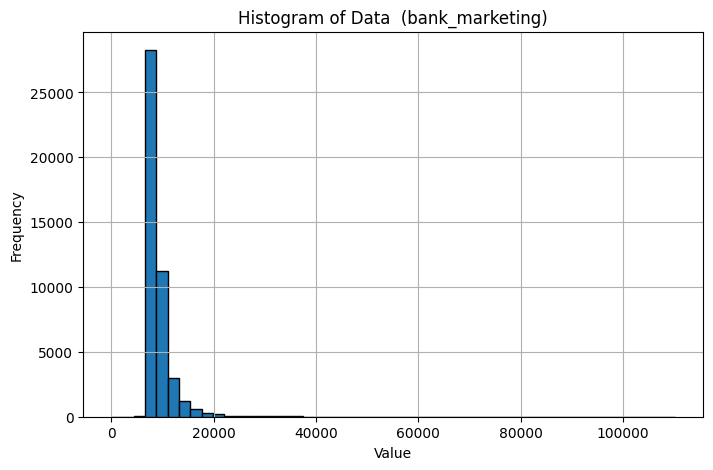

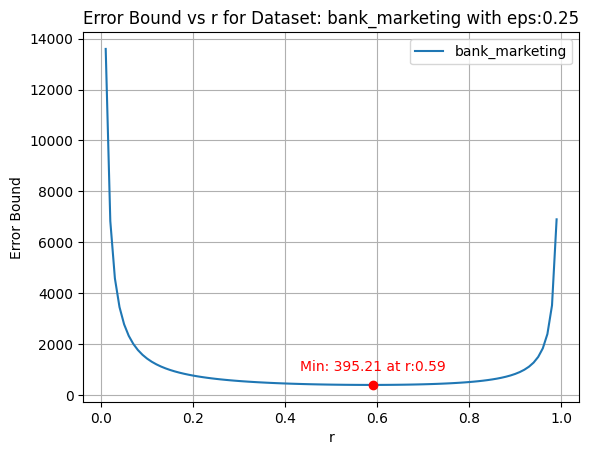

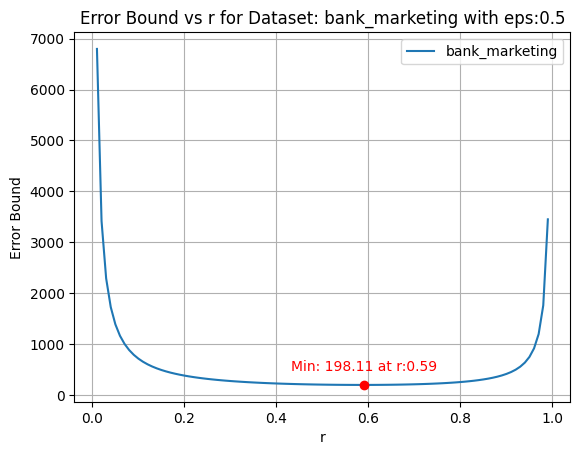

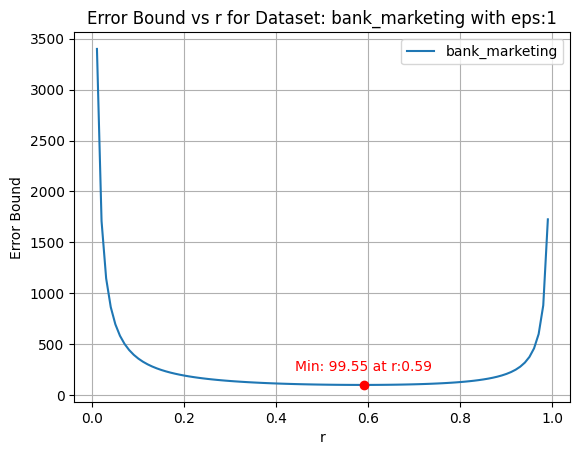

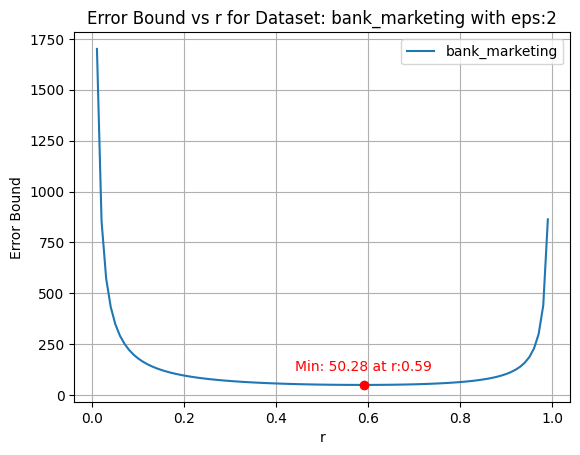

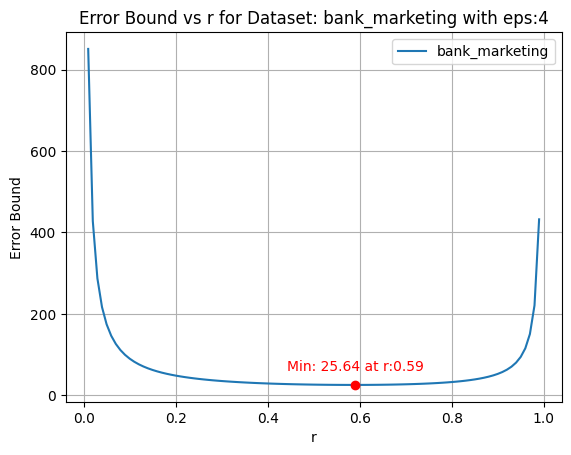

Dataset: adult
-----------adult-----------
lowest,hightest in the original dataset: 12285.0 1490400.0
Data_size: 48842
Domain size: 1478115.0
true median: 178144.5
true median rank: 24421.0


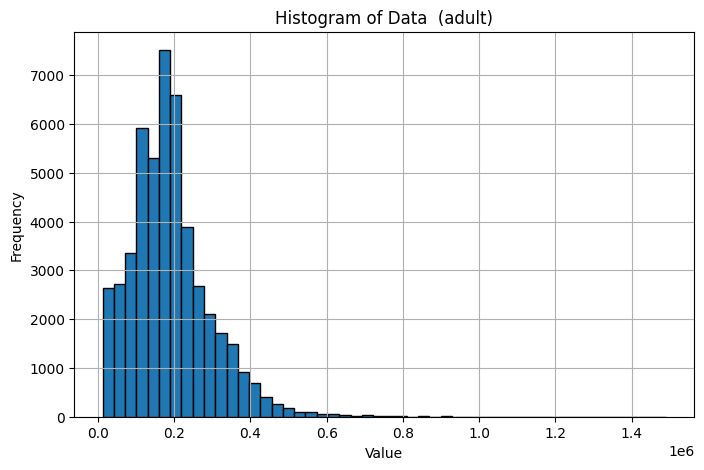

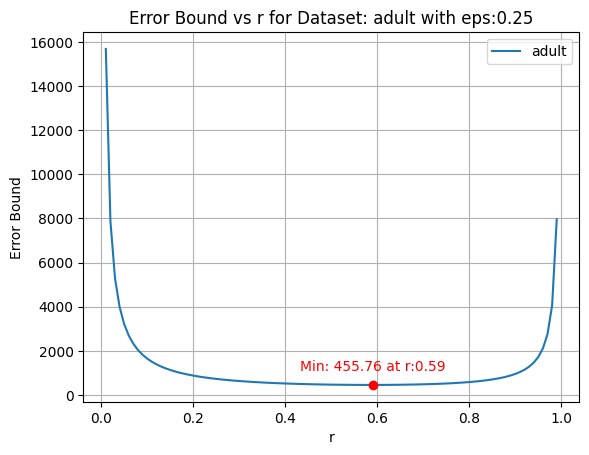

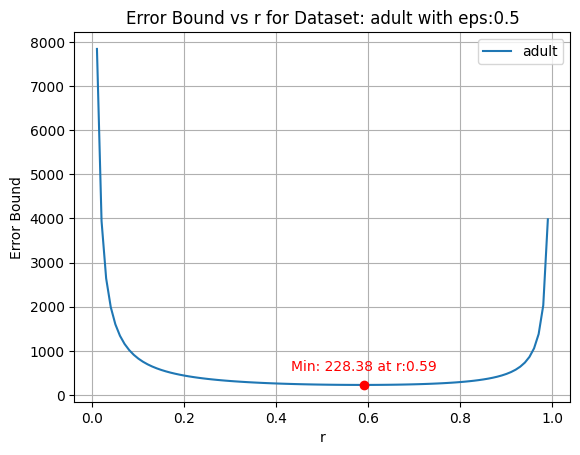

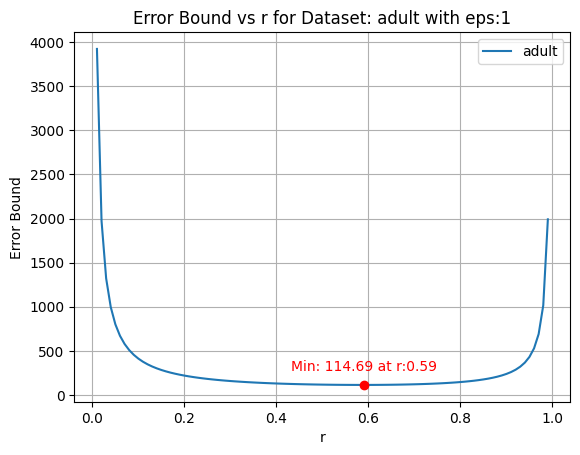

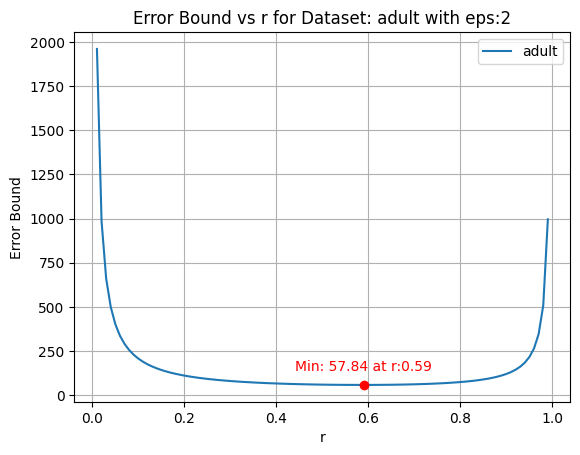

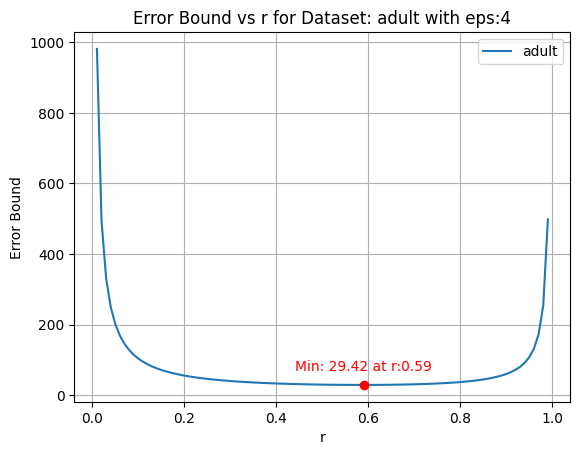

Dataset: cali_housing_test
-----------cali_housing_test-----------
lowest,hightest in the original dataset: 6.0 30450.0
Data_size: 3000
Domain size: 30444.0
true median: 2106.0
true median rank: 1500.0


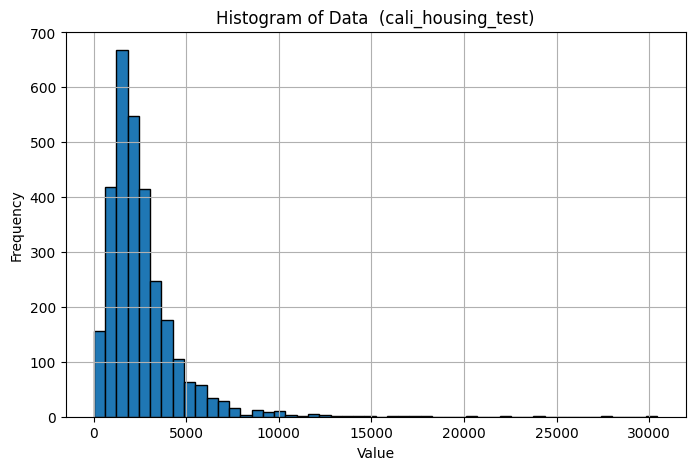

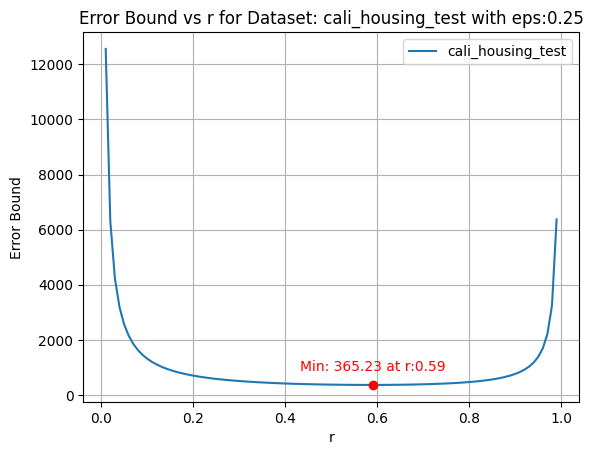

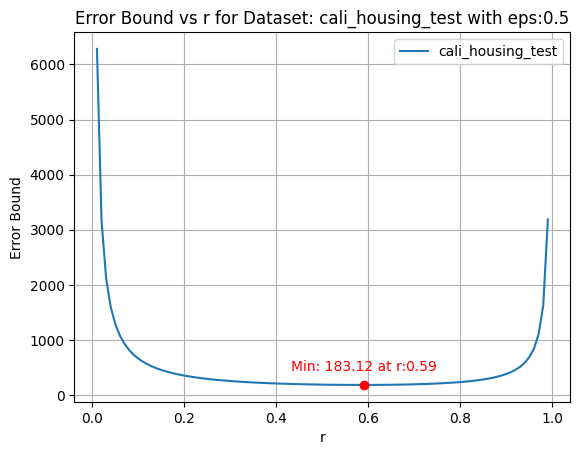

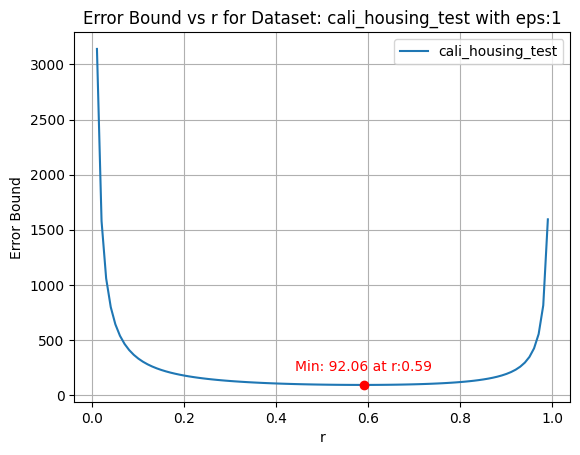

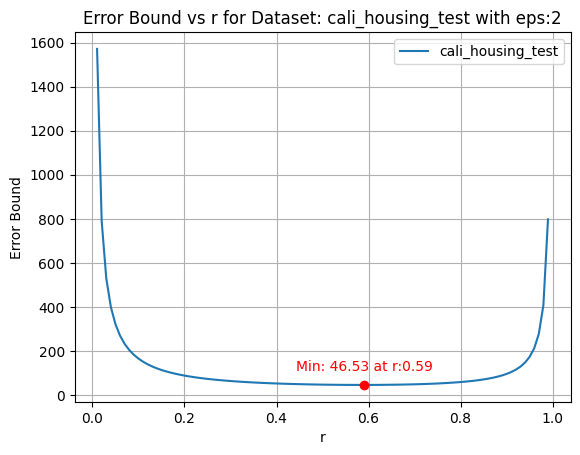

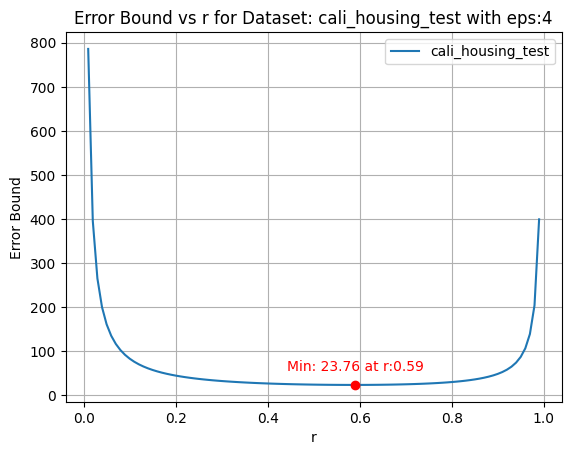

Dataset: cali_housing_value
-----------cali_housing_value-----------
lowest,hightest in the original dataset: 22500.0 500001.0
Data_size: 3000
Domain size: 477501.0
true median: 177650.0
true median rank: 1500.0


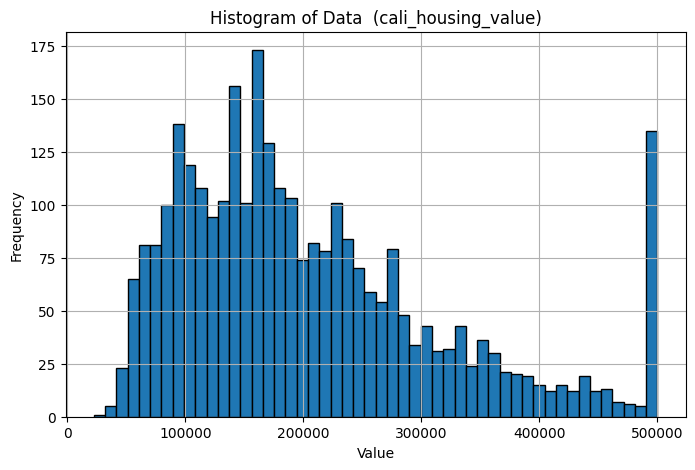

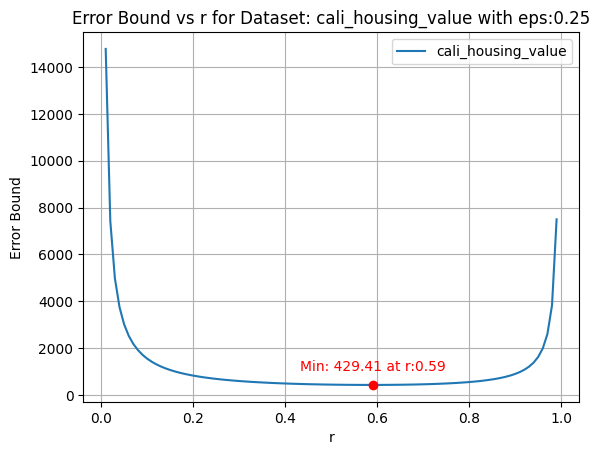

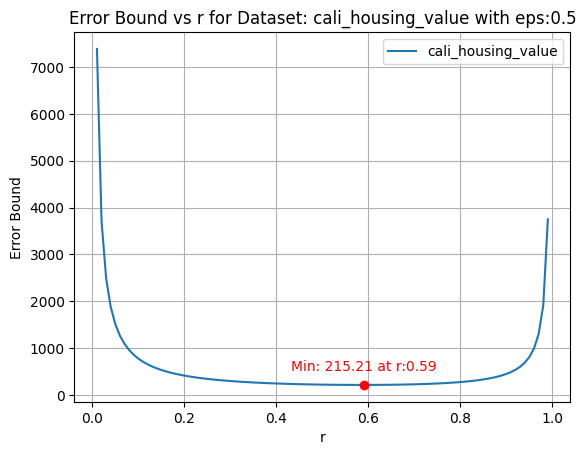

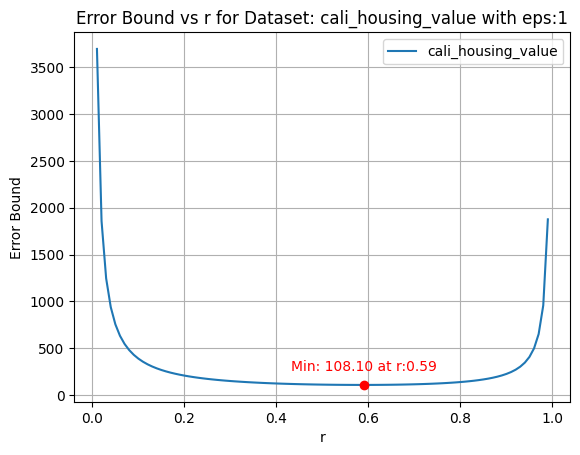

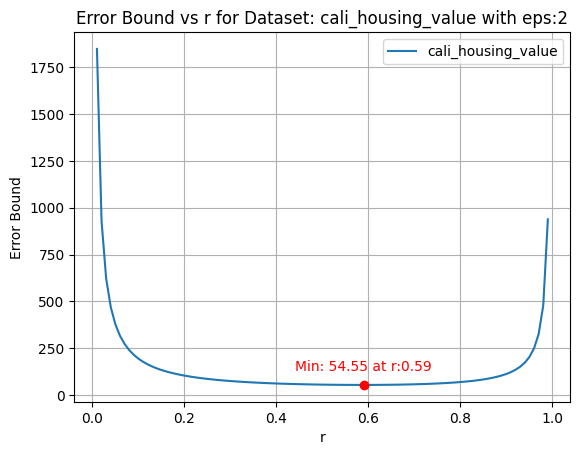

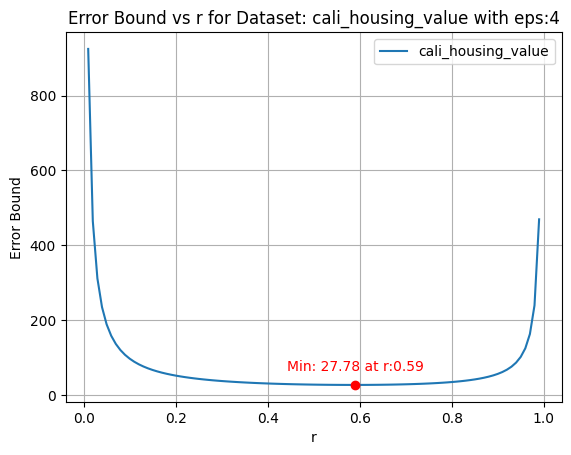

Dataset: IMDB_time
-----------IMDB_time-----------
lowest,hightest in the original dataset: 789652009.0 1476640644.0
Data_size: 100004
Domain size: 686988635.0
true median: 1110421822.0
true median rank: 50002.0


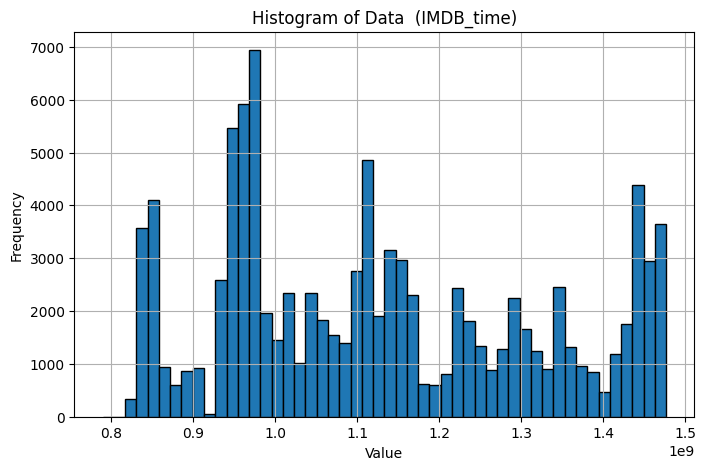

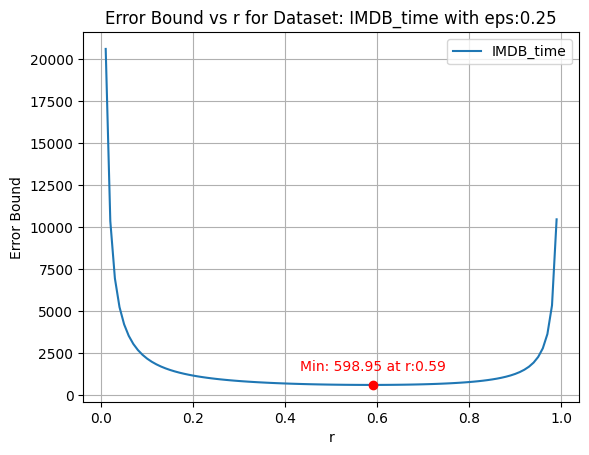

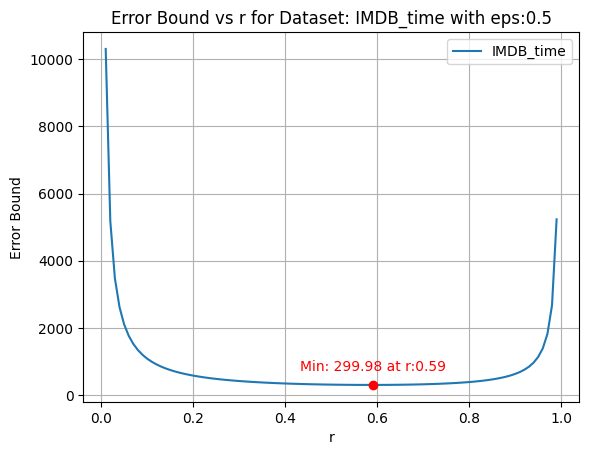

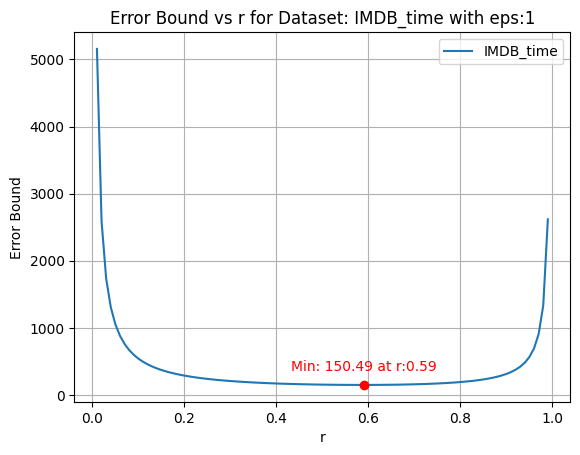

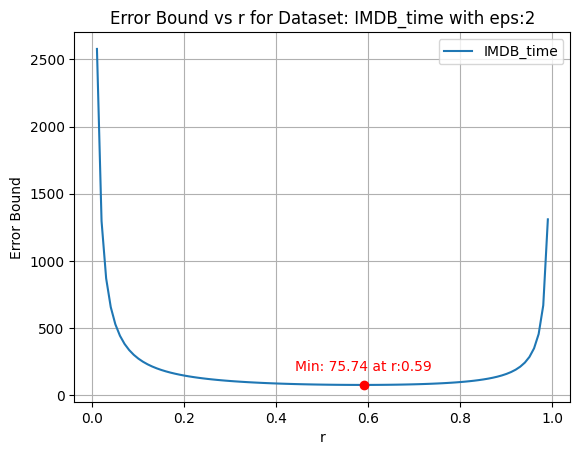

KeyboardInterrupt: 

In [62]:
  # Test error bound with diff eps splitting for all datasets
import matplotlib.pyplot as plt
dataset_id_dict = {0:"bank_marketing", 1:"adult", 2:"cali_housing_test", 3:"cali_housing_value",
           5:"IMDB_time",6:"airplane_capacity",7:"airplane_range",8:"airplane_maintenance",9:"airplane_price",
           10: "old_synthetic_data",11:"healthcare_age",12:"healthcare_bill"}
eps_list = [0.25,0.5,1,2,4]
for mode,data_uuid in dataset_id_dict.items():
    Load_and_Process_data(mode=mode)
    for eps_val in eps_list:
      error_bound_values = []
      eps = [eps_val]
      r_values = np.arange(0.01, 1, 0.01)
      min_error_bound = float('inf')
      min_r_value = None
      min_error = None
      for r in r_values:
        eps_1 = float(r * eps_val)
        eps_2 = float(eps_val - eps_1)
        b_list_step = 1
        l = 1
        # b_list_step = 1
        b_list = range(0, b_list_step*int(domain_size/b_list_step),b_list_step)
        if (len(b_list) == 0): b_list = range(0,1)
        C1 = (2/eps_1) *(np.log(domain_size/beta_1))
        C2 = (1/eps_2) *(np.log(domain_size/(b_list_step*beta_2)))
        m = len(b_list)
        if (m == 0): print("m=0, r=:",r)
        error_bound = C1 + C2 + l * b_list_step
        error_bound_values.append(error_bound)
        if error_bound < min_error_bound:
          min_error_bound = error_bound
          min_r_value = r
          min_error = error_bound
      # Plot
      plt.plot(r_values, error_bound_values, label=data_uuid)
      plt.scatter(min_r_value, min_error, color='red', zorder=5)
      plt.annotate(f"Min: {min_error:.2f} at r:{min_r_value}",
              (min_r_value, min_error),
              textcoords="offset points",
              xytext=(0,10),
              ha='center', color='red')


      plt.title(f"Error Bound vs r for Dataset: {data_uuid} with eps:{eps_val}")
      plt.xlabel("r")
      plt.ylabel("Error Bound")
      plt.legend(loc="best")
      plt.grid(True)
      plt.show()

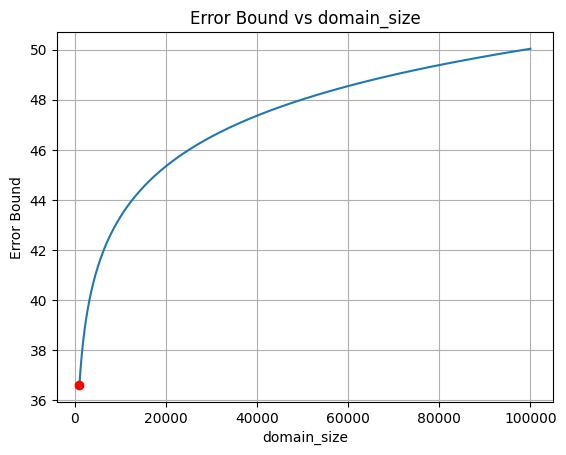

In [63]:
# Test error bound with diff domain_size
import matplotlib.pyplot as plt
eps_list = [0.25,0.5,1,2,4]
domain_sizes = range(1000,100000,1)
error_bound_values = []
min_error_bound = float('inf')
min_domain = None
min_error = None
r = 0.6
eps_val = 2
l = 1
eps_1 = float(r * eps_val)
eps_2 = float(eps_val - eps_1)
for domain_size in domain_sizes:
  optimized_step = int(2/eps_2)
  b_list_step = 1
  # b_list_step = 1
  b_list = range(b_list_step, b_list_step*int(domain_size/b_list_step),b_list_step)
  C1 = (2/eps_1) *(np.log(domain_size/beta_1))
  C2 = (1/eps_2) *(np.log(domain_size/(b_list_step*beta_2)))
  m = len(b_list)
  # alpha = (8*np.log(m)+np.log(2/beta_2)) / eps_2
  if (m == 0): print("m=0, r=:",r)
  error_bound = C1 + C2 + b_list_step
  error_bound_values.append(error_bound)
  if error_bound < min_error_bound:
    min_error_bound = error_bound
    min_domain = domain_size
    min_error = error_bound
plt.plot(domain_sizes, error_bound_values, label=data_uuid)
plt.scatter(min_domain, min_error, color='red', zorder=5)



plt.title(f"Error Bound vs domain_size")
plt.xlabel("domain_size")
plt.ylabel("Error Bound")
plt.grid(True)
plt.show()

In [72]:
# see eps splitting
import math

N = 1000
beta1 = 0.005
beta2 = 0.005
epsilon = 1
max_iterations = 100
# s = 2/(2/3)
s = 1
def calculate_epsilon_1(epsilon_2, N, beta1, beta2, s):
  return epsilon_2 * math.sqrt(math.log(N / beta1) / math.log(N / (s * beta2)))


def iterative_optimization(N, beta1, beta2, epsilon, max_iterations):
  global s
  iteration = 0
  while iteration < max_iterations:
    denominator = 1 + math.sqrt(math.log(N / beta1) / math.log(N / (s * beta2)))
    epsilon_2 = epsilon / denominator
    epsilon_1 = calculate_epsilon_1(epsilon_2, N, beta1, beta2, s)
    epsilon_2 = epsilon_2
    s = int(2/epsilon_2)
    iteration += 1
    print(s)
    # print(epsilon_1,epsilon_2)
  return epsilon_1, epsilon_2

D = discrete(readInput(0))
n = len(D)
lowest = int(min(D))
highest = int(max(D))
domain_size = highest - lowest
eps_1,eps_2 = iterative_optimization(N, beta1, beta2, epsilon, max_iterations)
print(eps_1,eps_2)
C1 = (2/eps_1) *(np.log(domain_size/beta_1))
C2 = (1/eps_2) *(np.log(domain_size/(b_list_step*beta_2)))
b_list_step = 2/eps_2
error_bound = C1 + C2 + b_list_step
print(error_bound)

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0.5150651640867288 0.4849348359132714
165.44859410990676
